In [1]:
import os 
import sys

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
from matplotlib.ticker import LinearLocator


sys.path.append("../src/modeval")
from modulescomparison import ModulesComparison
from modulecontainers import Modules 

In [2]:
sys.path.insert(0,os.path.abspath("../src/modeval/"))

In [3]:
## Get the known RegulonDB network with modification described in inspect_input_elements.ipynb
known_trn = pd.read_csv("../data/Regulatory/QCd_Network.csv", index_col=0)
known_trn.head()

,regulatorId,regulatorName,RegulatorGeneName,regulatedId,regulatedName,function,confidenceLevel
313,RDBECOLIPDC00358,DsrA,dsrA,RDBECOLIGNC00450,hns,-,S
315,RDBECOLIPDC00358,DsrA,dsrA,RDBECOLIGNC00539,lrp,-,S
316,RDBECOLIPDC00358,DsrA,dsrA,RDBECOLIGNC00804,rbsA,-,S
317,RDBECOLIPDC00358,DsrA,dsrA,RDBECOLIGNC00805,rbsB,-,S
318,RDBECOLIPDC00358,DsrA,dsrA,RDBECOLIGNC00806,rbsC,-,S


In [4]:
## Load the annotation E Coli 
annotation = pd.read_csv("../data/Annotation/gene_info.csv")
annotation.head()

,locus_tag,gene_name,old_locus_tag,start,end,strand,gene_product,COG,uniprot
0,b0001,thrL,NaN,190,255,+,thr operon leader peptide,No COG annotation,P0AD86
1,b0002,thrA,NaN,337,2799,+,fused aspartate kinase/homoserine dehydrogenase 1,Amino acid transport and metabolism,P00561
2,b0003,thrB,NaN,2801,3733,+,homoserine kinase,Nucleotide transport and metabolism,P00547
3,b0004,thrC,NaN,3734,5020,+,threonine synthase,Amino acid transport and metabolism,P00934
4,b0005,yaaX,NaN,5234,5530,+,DUF2502 domain-containing protein YaaX,Function unknown,P75616


In [5]:
# Define the set of all known genes (E)
all_genes = annotation.locus_tag.values 

# Define a set of all known regulators
known_regulators = known_trn['RegulatorGeneName'].unique()

# Map gene names to locus tags for comparable output with GENIE3 ouput
annotation_map = annotation[annotation.gene_name.notna()].set_index("gene_name")["locus_tag"].to_dict()
known_trn['targets_tags'] = known_trn["regulatedName"].map(annotation_map)

In [6]:
known_trn.head()

,regulatorId,regulatorName,RegulatorGeneName,regulatedId,regulatedName,function,confidenceLevel,targets_tags
313,RDBECOLIPDC00358,DsrA,dsrA,RDBECOLIGNC00450,hns,-,S,b1237
315,RDBECOLIPDC00358,DsrA,dsrA,RDBECOLIGNC00539,lrp,-,S,b0889
316,RDBECOLIPDC00358,DsrA,dsrA,RDBECOLIGNC00804,rbsA,-,S,b3749
317,RDBECOLIPDC00358,DsrA,dsrA,RDBECOLIGNC00805,rbsB,-,S,b3751
318,RDBECOLIPDC00358,DsrA,dsrA,RDBECOLIGNC00806,rbsC,-,S,b3750


In [7]:
# Iterate over regulators and gene targets to load a graph from edges
known_ecoli_trn = nx.Graph() 
for i in known_trn[['RegulatorGeneName', 'targets_tags']].itertuples():
    known_ecoli_trn.add_edges_from([tuple([i[1], i[2]])]) 
    
edges_ecoli_trn = known_ecoli_trn.edges

# Find the neighbors of the regulators to define gene targets 
known_modules = []
for reg in known_regulators:
    known_modules.append(list(known_ecoli_trn.neighbors(reg)))

In [8]:
known_modules

[['b1237', 'b0889', 'b3749', 'b3751', 'b3750', 'b3748', 'b3752', 'b3753'],
 ['b3300',
  'b3308',
  'b3305',
  'b3310',
  'b3301',
  'b3304',
  'b3309',
  'b3302',
  'b3303',
  'b3306',
  'b3307',
  'b3299'],
 ['b0781',
  'b0782',
  'b0784',
  'b0785',
  'b0783',
  'b2573',
  'b4722',
  'b4720',
  'b4721',
  'b1044',
  'b4326',
  'b3429',
  'b3430',
  'b3428',
  'b1916',
  'b0020',
  'b1535',
  'b1021',
  'b1022',
  'b1023',
  'b1024',
  'b1025'],
 ['b0598', 'b1761', 'b3771', 'b0889', 'b0168', 'b1130', 'b1129', 'b1534'],
 ['b1891', 'b1892', 'b1037', 'b1038', 'b1039', 'b1040'],
 ['b1817', 'b1818', 'b1819', 'b1101', 'b1658', 'b2152', 'b2153', 'b4116'],
 ['b2599', 'b1260', 'b1261', 'b1262', 'b1263', 'b1264', 'b1265', 'b1661'],
 ['b2296', 'b3891', 'b3942', 'b3892', 'b3893', 'b3894'],
 ['b2741', 'b3511', 'b2193', 'b1037', 'b1038', 'b1039', 'b1040', 'b1341'],
 ['b0553',
  'b0929',
  'b3751',
  'b0721',
  'b2594',
  'b0805',
  'b1037',
  'b1038',
  'b1039',
  'b1040'],
 ['b2741', 'b1740', 'b35

In [9]:
known_regulators

array(['dsrA', 'rpsH', 'csrA', 'gcvB', 'mcaS', 'sgrS', 'rydC', 'sdhX',
       'rprA', 'rybB', 'cyaR', 'omrB', 'spf', 'micA', 'omrA', 'ryhB',
       'fliX', 'agaR', 'tdcA', 'narL', 'tdcR', 'fliZ', 'lrp', 'mqsA',
       'dnaA', 'csgD', 'hns', 'araC', 'dcuR', 'nagC', 'mlrA', 'trpR',
       'modE', 'zur', 'lldR', 'nsrR', 'ompR', 'chbR', 'rcsB', 'rcdA',
       'rob', 'flhD;flhC', 'fis', 'pgrR', 'iscR', 'cra', 'rbsR', 'torR',
       'acrR', 'stpA', 'cbl', 'soxR', 'fhlA', 'hprR', 'marA', 'zraR',
       'argP', 'gadE', 'tyrR', 'cecR', 'glaR', 'plaR', 'nhaR', 'narP',
       'galR', 'mcbR', 'xylR', 'hcaR', 'fur', 'arcA', 'glpR', 'sutR',
       'kdpE', 'sgrR', 'argR', 'pspF', 'paaX', 'cytR', 'matA', 'caiF',
       'cusR', 'purR', 'rcsB;gadE', 'fadR', 'fnr', 'nac', 'slyA', 'ycjW',
       'ydeO', 'nrdR', 'cysB', 'glnG', 'nanR', 'mhpR', 'pdhR', 'rhaS',
       'rutR', 'malT', 'lsrR', 'phoP', 'btsR', 'cpxR', 'dpiA', 'mraZ',
       'adiY', 'gntR', 'pdeL', 'evgA', 'baeR', 'allR', 'yhaJ', 'gadX',
       

In [10]:
## Load the results from GENIE3 undirected run w/o regulator input
genie3_undirected = pd.read_csv("../data/predicted_results/GENIE3_5_ET_Ksqrt_nTrees1000_nRegs0_2024-06-11.csv", index_col=0)
genie3_undirected.head()

,regulatoryGene,targetGene,weight
1,b0573,b0574,0.041188
2,b0575,b0574,0.039607
3,b0574,b0575,0.039262
4,b2000,b2001,0.038284
5,b1973,b0296,0.035970


In [11]:
## Load the results from GENIE3 directed run w/o regulator input
genie3_directed = pd.read_csv("../data/predicted_results/GENIE3_4_RF_Ksqrt_nTrees1000_nRegs106_2024-06-26.csv", index_col=0)
genie3_directed.head()

,regulatoryGene,targetGene,weight
1,b1921,b1071,0.344796
2,b1921,b1924,0.340820
3,b0571,b0572,0.339699
4,b1921,b1925,0.336633
5,b1921,b1926,0.330987


In [13]:
directed_list_edges = []
undirected_list_edges = []

for j in range (1000,10000,1000):
    ecoli_trn_undirected = nx.Graph()
    ecoli_trn_undirected.add_edges_from([tuple(val) for val in genie3_undirected[['regulatoryGene', 'targetGene']].head(j).values])
    ecoli_trn_directed = nx.Graph()
    ecoli_trn_directed.add_edges_from([tuple(val) for val in genie3_directed[['regulatoryGene', 'targetGene']].head(j).values])
    regulator_ids = annotation[annotation['gene_name'].isin(known_regulators)]['locus_tag'].values

    modules_undirected = []
    for reg in regulator_ids:
        if reg in ecoli_trn_undirected.nodes:
            module = list(ecoli_trn_undirected.neighbors(reg))
            modules_undirected.append(module)

    # Get the sets 
    undirected_modules_as_sets = [set(module) for module in modules_undirected]
    
    modules_directed = []
    for reg in regulator_ids:
        if reg in ecoli_trn_directed.nodes:
            module = list(ecoli_trn_directed.neighbors(reg))
            modules_directed.append(module)

    # Get the sets 
    directed_modules_as_sets = [set(module) for module in modules_directed]

    ModulesB = Modules(known_modules)
    ModulesA_directed = Modules(directed_modules_as_sets)
    ModulesA_undirected = Modules(undirected_modules_as_sets)

    undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)
    direct_comp = ModulesComparison(ModulesA_directed, ModulesB, all_genes).score(None)

    directed_list_edges.append((j, direct_comp['precision'], direct_comp['recall'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rprr']))
    undirected_list_edges.append((j, undirect_comp['precision'], undirect_comp['recall'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rprr']))

directed_scores_edges = pd.DataFrame(directed_list_edges, columns=['edges', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])
undirected_scores_edges = pd.DataFrame(undirected_list_edges, columns=['edges', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])

In [15]:
directed_scores_edges

,edges,precision,recall,recovery,relevance,f1rprr
0,1000,0.018158,0.043420,0.162591,0.151404,0.044025
1,2000,0.019596,0.044141,0.155423,0.162716,0.046369
2,3000,0.022360,0.044060,0.167148,0.164862,0.050335
3,4000,0.024059,0.041812,0.159182,0.156025,0.051169
4,5000,0.025528,0.039729,0.160024,0.151405,0.051815
5,6000,0.026991,0.037723,0.154671,0.144246,0.051977
6,7000,0.028756,0.035604,0.151017,0.138147,0.052136
7,8000,0.030479,0.034682,0.146689,0.134381,0.052700
8,9000,0.031665,0.032290,0.141946,0.128530,0.051696


In [16]:
undirected_scores_edges

,edges,precision,recall,recovery,relevance,f1rprr
0,1000,0.000423,0.004112,0.429534,0.020204,0.001504
1,2000,0.000801,0.007031,0.252392,0.048363,0.002827
2,3000,0.003321,0.014123,0.341122,0.074941,0.010304
3,4000,0.005962,0.020197,0.289529,0.085376,0.017212
4,5000,0.007408,0.023202,0.253666,0.093429,0.020754
5,6000,0.009456,0.026102,0.229935,0.102749,0.025293
6,7000,0.009923,0.026874,0.229111,0.104298,0.026326
7,8000,0.010129,0.028217,0.226597,0.111721,0.027114
8,9000,0.011143,0.029468,0.197657,0.116460,0.029129


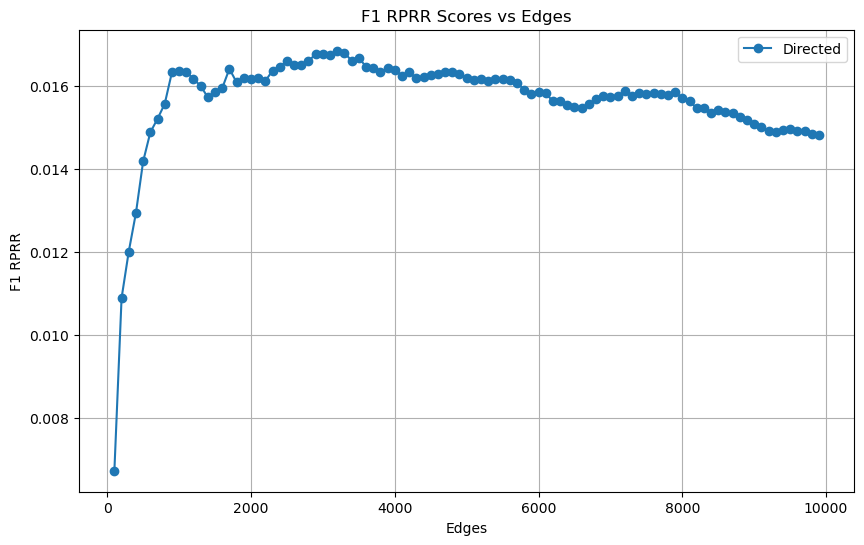

In [22]:
plt.figure(figsize=(10, 6))

# Plot for directed scores
plt.plot(directed_scores_edges['edges'], directed_scores_edges['f1rprr'], marker='o', linestyle='-', label='Directed')
plt.xlabel('Edges')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Edges')
plt.legend()
plt.grid(True)
plt.show()

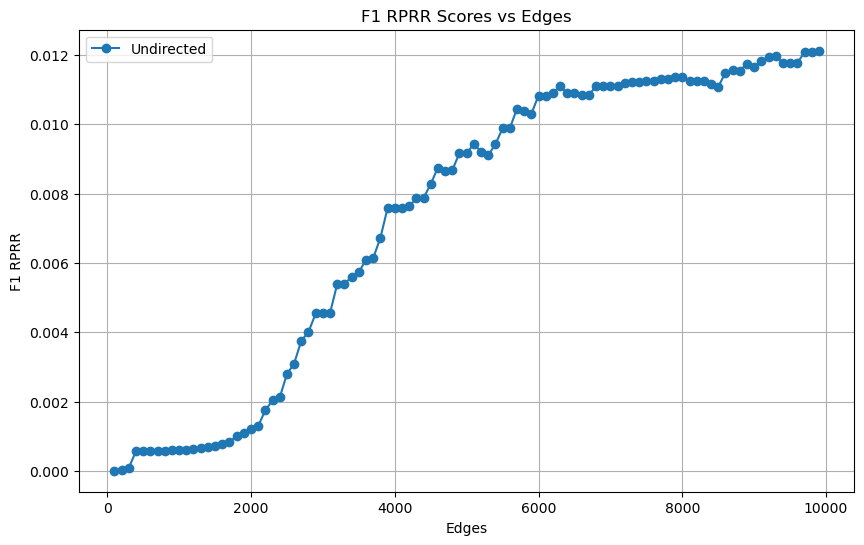

In [23]:
plt.figure(figsize=(10, 6))

# Plot for undirected scores
plt.plot(undirected_scores_edges['edges'], undirected_scores_edges['f1rprr'], marker='o', linestyle='-', label='Undirected')
plt.xlabel('Edges')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Edges')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
max_undirected_score_edges = undirected_scores_edges.loc[undirected_scores_edges['f1rprr'].idxmax()]
max_directed_score_edges = directed_scores_edges.loc[directed_scores_edges['f1rprr'].idxmax()]

print("Edge count with highest undirected F1rprr score:")
print(max_undirected_score_edges)
print("Edge count with highest directed F1rprr score:")
print(max_directed_score_edges)

Edge count with highest undirected F1rprr score:
edges        9900.000000
precision       0.004453
recall          0.010987
recovery        0.172779
relevance       0.115511
f1rprr          0.012120
Name: 98, dtype: float64
Edge count with highest directed F1rprr score:
edges        3200.000000
precision       0.007689
recall          0.010928
recovery        0.127665
relevance       0.126686
f1rprr          0.016857
Name: 31, dtype: float64


In [ ]:
directed_scores_edges.to_csv('../results/directed_scores_edges.csv', index=False)

In [ ]:
undirected_scores_edges.to_csv('../results/undirected_scores_edges.csv', index=False)

In [25]:
directed_list_edges = []
undirected_list_edges = []

for j in range (100,10000,100):
    ecoli_trn_undirected = nx.Graph()
    ecoli_trn_undirected.add_edges_from([tuple(val) for val in genie3_undirected[['regulatoryGene', 'targetGene']].head(j).values])
    ecoli_trn_directed = nx.Graph()
    ecoli_trn_directed.add_edges_from([tuple(val) for val in genie3_directed[['regulatoryGene', 'targetGene']].head(j).values])
    louvain_community_undirected = nx.community.louvain_communities(ecoli_trn_undirected, weight='weight', resolution=1, threshold=1e-7, seed=None)
    louvain_community_directed = nx.community.louvain_communities(ecoli_trn_directed, weight='weight', resolution=1, threshold=1e-7, seed=None)
    louvain_directed_sets = [set(module) for module in louvain_community_directed]
    louvain_undirected_sets = [set(module) for module in louvain_community_undirected]
    ModulesB = Modules(known_modules)
    ModulesA_directed = Modules(louvain_directed_sets)
    ModulesA_undirected = Modules(louvain_undirected_sets)

    undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)
    direct_comp = ModulesComparison(ModulesA_directed, ModulesB, all_genes).score(None)

    directed_list_edges.append((j, direct_comp['precision'], direct_comp['recall'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rprr']))
    undirected_list_edges.append((j, undirect_comp['precision'], undirect_comp['recall'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rprr']))

directed_scores_edges = pd.DataFrame(directed_list_edges, columns=['edges', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])
undirected_scores_edges = pd.DataFrame(undirected_list_edges, columns=['edges', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])

In [26]:
directed_scores_edges

,edges,precision,recall,recovery,relevance,f1rprr
0,100,0.003072,0.006595,0.364974,0.072843,0.008103
1,200,0.004838,0.012334,0.288819,0.127552,0.013374
2,300,0.005313,0.013826,0.253103,0.140376,0.014726
3,400,0.005710,0.015181,0.251008,0.150304,0.015896
4,500,0.006085,0.016634,0.229708,0.155251,0.017004
...,...,...,...,...,...,...
94,9500,0.006440,0.005445,0.089623,0.028373,0.010380
95,9600,0.006260,0.005302,0.096270,0.027748,0.010132
96,9700,0.006471,0.005720,0.092066,0.029812,0.010701
97,9800,0.006635,0.005742,0.093572,0.028829,0.010803


In [27]:
undirected_scores_edges

,edges,precision,recall,recovery,relevance,f1rprr
0,100,0.000404,0.002956,0.142815,0.037747,0.001406
1,200,0.000567,0.005528,0.140908,0.065594,0.002035
2,300,0.000700,0.007196,0.153593,0.084282,0.002523
3,400,0.001172,0.009957,0.153647,0.098142,0.004123
4,500,0.001259,0.011827,0.156166,0.113536,0.004475
...,...,...,...,...,...,...
94,9500,0.014022,0.047709,0.098930,0.272630,0.037718
95,9600,0.014131,0.047410,0.098850,0.272492,0.037863
96,9700,0.014222,0.046800,0.098128,0.268194,0.037879
97,9800,0.014198,0.046769,0.097956,0.268584,0.037826


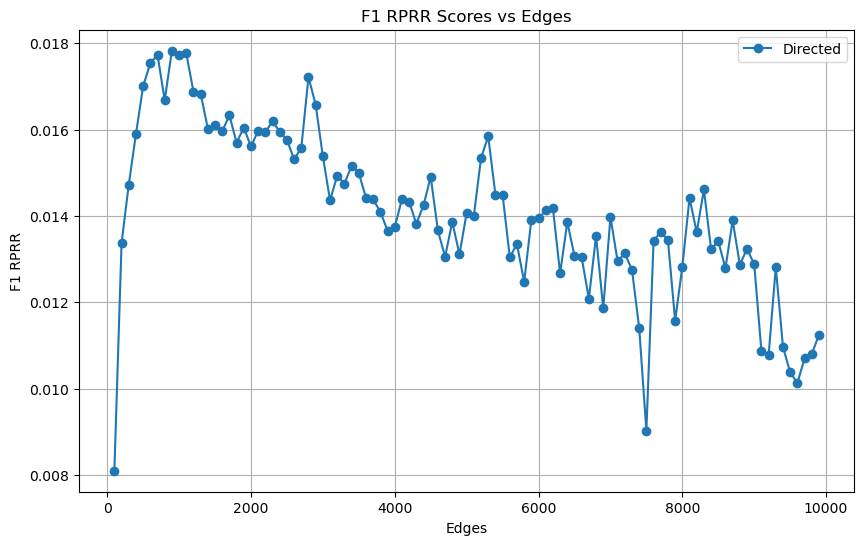

In [28]:
plt.figure(figsize=(10, 6))

# Plot for directed scores
plt.plot(directed_scores_edges['edges'], directed_scores_edges['f1rprr'], marker='o', linestyle='-', label='Directed')
plt.xlabel('Edges')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Edges')
plt.legend()
plt.grid(True)
plt.show()

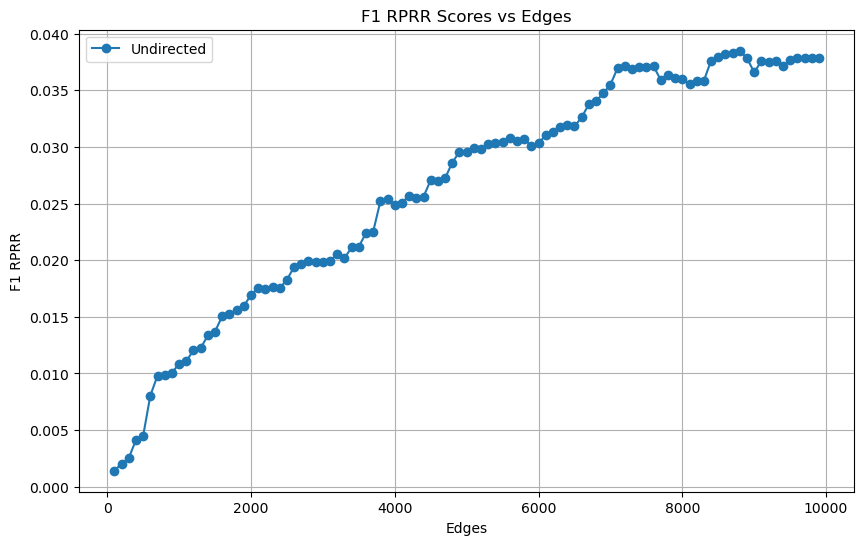

In [29]:
plt.figure(figsize=(10, 6))

# Plot for undirected scores
plt.plot(undirected_scores_edges['edges'], undirected_scores_edges['f1rprr'], marker='o', linestyle='-', label='Undirected')
plt.xlabel('Edges')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Edges')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
max_undirected_score_edges = undirected_scores_edges.loc[undirected_scores_edges['f1rprr'].idxmax()]
max_directed_score_edges = directed_scores_edges.loc[directed_scores_edges['f1rprr'].idxmax()]

print("Edge count with highest undirected F1rprr score:")
print(max_undirected_score_edges)
print("Edge count with highest directed F1rprr score:")
print(max_directed_score_edges)

Edge count with highest undirected F1rprr score:
edges        8800.000000
precision       0.014348
recall          0.048248
recovery        0.101855
relevance       0.273761
f1rprr          0.038501
Name: 87, dtype: float64
Edge count with highest directed F1rprr score:
edges        900.000000
precision      0.006767
recall         0.015537
recovery       0.177181
relevance      0.150753
f1rprr         0.017824
Name: 8, dtype: float64


In [35]:
directed_scores_edges.to_csv('../results/directed_scores_edges_louvain.csv', index=False)

In [36]:
undirected_scores_edges.to_csv('../results/undirected_scores_edges_louvain.csv', index=False)

In [31]:
ecoli_trn_undirected = nx.Graph()
ecoli_trn_undirected.add_edges_from([tuple(val) for val in genie3_undirected[['regulatoryGene', 'targetGene']].head(1000).values])
ecoli_trn_directed = nx.Graph()
ecoli_trn_directed.add_edges_from([tuple(val) for val in genie3_directed[['regulatoryGene', 'targetGene']].head(1000).values])

In [ ]:
directed_list_res = []
undirected_list_res = []

for j in range (10,100,1):
    louvain_community_undirected = nx.community.louvain_communities(ecoli_trn_undirected, weight='weight', resolution=(j/10), threshold=1e-7, seed=None)
    louvain_community_directed = nx.community.louvain_communities(ecoli_trn_directed, weight='weight', resolution=(j/10), threshold=1e-7, seed=None)
    louvain_directed_sets = [set(module) for module in louvain_community_directed]
    louvain_undirected_sets = [set(module) for module in louvain_community_undirected]
    ModulesB = Modules(known_modules)
    ModulesA_directed = Modules(louvain_directed_sets)
    ModulesA_undirected = Modules(louvain_undirected_sets)
    undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)
    direct_comp = ModulesComparison(ModulesA_directed, ModulesB, all_genes).score(None)

    directed_list_res.append((j/10, direct_comp['precision'], direct_comp['recall'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rprr']))
    undirected_list_res.append((j/10, undirect_comp['precision'], undirect_comp['recall'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rprr']))

directed_scores_res = pd.DataFrame(directed_list_res, columns=['resolution', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])
undirected_scores_res = pd.DataFrame(undirected_list_res, columns=['resolution', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])

KeyboardInterrupt: 

In [ ]:
undirected_scores_res

,resolution,precision,recall,recovery,relevance,f1rprr
0,1.0,0.003289,0.019756,0.141503,0.152012,0.010860
1,1.1,0.003289,0.019756,0.141503,0.152012,0.010860
2,1.2,0.003289,0.019756,0.141503,0.152012,0.010860
3,1.3,0.003289,0.019756,0.141503,0.152012,0.010860
4,1.4,0.003289,0.019756,0.141503,0.152012,0.010860
...,...,...,...,...,...,...
85,9.5,0.001550,0.016880,0.131622,0.148569,0.005564
86,9.6,0.001542,0.016846,0.130360,0.148292,0.005539
87,9.7,0.001542,0.016878,0.132590,0.148841,0.005541
88,9.8,0.001527,0.016895,0.131847,0.148239,0.005490


In [ ]:
directed_scores_res

,resolution,precision,recall,recovery,relevance,f1rprr
0,1.0,0.006832,0.014902,0.169820,0.142186,0.017669
1,1.1,0.006864,0.014930,0.169733,0.142261,0.017732
2,1.2,0.006864,0.014930,0.169733,0.142261,0.017732
3,1.3,0.006864,0.014930,0.169733,0.142261,0.017732
4,1.4,0.007022,0.015486,0.174615,0.146086,0.018219
...,...,...,...,...,...,...
85,9.5,0.007489,0.018152,0.095515,0.158195,0.019472
86,9.6,0.007488,0.018134,0.093715,0.158350,0.019448
87,9.7,0.007489,0.018133,0.091352,0.158235,0.019422
88,9.8,0.007485,0.018131,0.091148,0.157740,0.019411


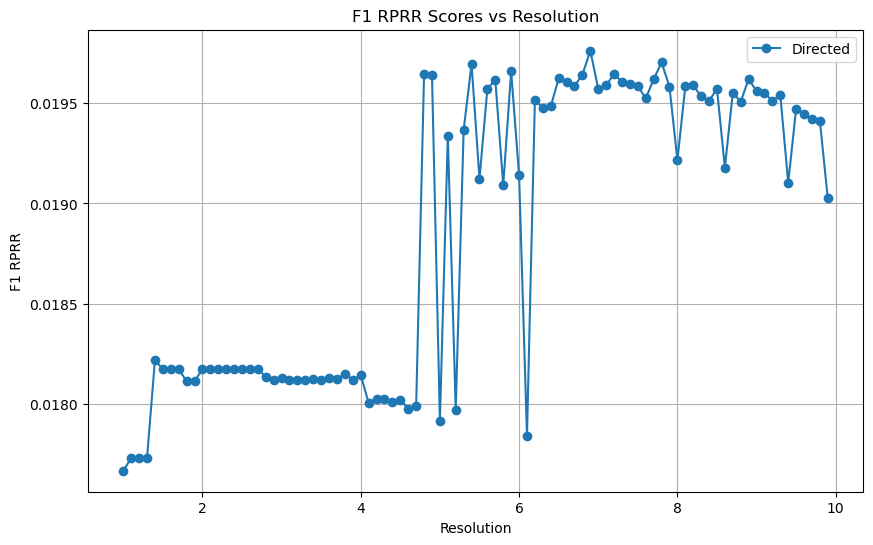

In [ ]:
plt.figure(figsize=(10, 6))

# Plot for directed scores
plt.plot(directed_scores_res['resolution'], directed_scores_res['f1rprr'], marker='o', linestyle='-', label='Directed')
plt.xlabel('Resolution')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Resolution')
plt.legend()
plt.grid(True)
plt.show()

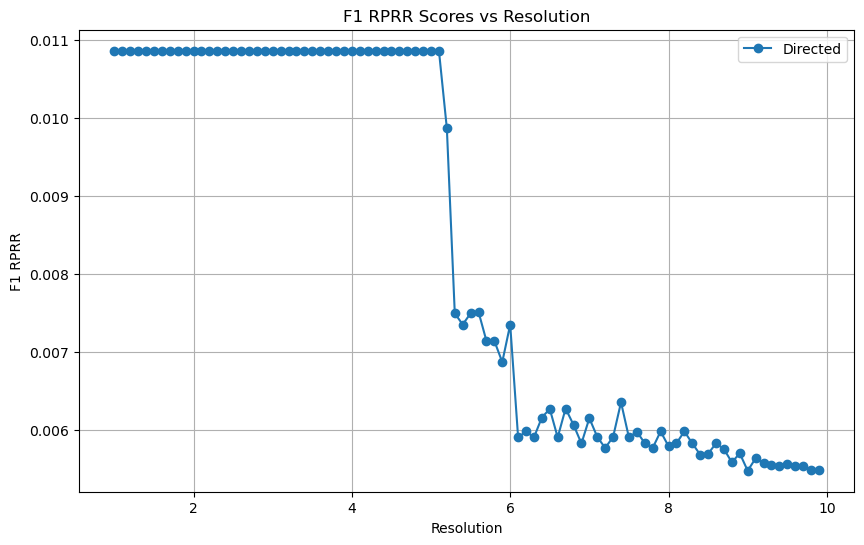

In [ ]:
plt.figure(figsize=(10, 6))

# Plot for undirected scores
plt.plot(undirected_scores_res['resolution'], undirected_scores_res['f1rprr'], marker='o', linestyle='-', label='Undirected')
plt.xlabel('Resolution')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Resolution')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
max_undirected_score_res = undirected_scores_res.loc[undirected_scores_res['f1rprr'].idxmax()]
max_directed_score_res = directed_scores_res.loc[directed_scores_res['f1rprr'].idxmax()]

print("Resolution with highest undirected F1rprr score:")
print(max_undirected_score_res)
print("Resolution with highest directed F1rprr score:")
print(max_directed_score_res)

Resolution with highest undirected F1rprr score:
resolution    1.000000
precision     0.003289
recall        0.019756
recovery      0.141503
relevance     0.152012
f1rprr        0.010860
Name: 0, dtype: float64
Resolution with highest directed F1rprr score:
resolution    6.900000
precision     0.007558
recall        0.018108
recovery      0.117365
relevance     0.157040
f1rprr        0.019761
Name: 59, dtype: float64


In [ ]:
directed_scores_edges.to_csv('../results/directed_scores_res_louvain.csv', index=False)

In [ ]:
undirected_scores_edges.to_csv('../results/undirected_scores_res_louvain.csv', index=False)

In [10]:
directed_list_thresh = []
undirected_list_thresh = []

for j in range (1,100,1):
    thresh = 10**-j
    louvain_community_undirected = nx.community.louvain_communities(ecoli_trn_undirected, weight='weight', resolution=1, threshold= thresh, seed=None)
    louvain_community_directed = nx.community.louvain_communities(ecoli_trn_directed, weight='weight', resolution=1, threshold= thresh, seed=None)
    louvain_directed_sets = [set(module) for module in louvain_community_directed]
    louvain_undirected_sets = [set(module) for module in louvain_community_undirected]
    ModulesB = Modules(known_modules)
    ModulesA_directed = Modules(louvain_directed_sets)
    ModulesA_undirected = Modules(louvain_undirected_sets)
    undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)
    direct_comp = ModulesComparison(ModulesA_directed, ModulesB, all_genes).score(None)
    directed_list_thresh.append((thresh, direct_comp['precision'], direct_comp['recall'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rprr']))
    undirected_list_thresh.append((thresh, undirect_comp['precision'], undirect_comp['recall'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rprr']))

directed_scores_thresh = pd.DataFrame(directed_list_thresh, columns=['threshold', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])
undirected_scores_thresh = pd.DataFrame(undirected_list_thresh, columns=['threshold', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])

NameError: name 'ecoli_trn_undirected' is not defined

In [ ]:
directed_scores_thresh

,threshold,precision,recall,recovery,relevance,f1rprr
0,1.000000e-01,0.006832,0.014902,0.169820,0.142186,0.017669
1,1.000000e-02,0.006864,0.014930,0.169733,0.142261,0.017732
2,1.000000e-03,0.006864,0.014930,0.169733,0.142261,0.017732
3,1.000000e-04,0.006864,0.014930,0.169733,0.142261,0.017732
4,1.000000e-05,0.006864,0.014930,0.169733,0.142261,0.017732
...,...,...,...,...,...,...
94,1.000000e-95,0.006864,0.014930,0.169733,0.142261,0.017732
95,1.000000e-96,0.006864,0.014930,0.169733,0.142261,0.017732
96,1.000000e-97,0.006864,0.014930,0.169733,0.142261,0.017732
97,1.000000e-98,0.006864,0.014930,0.169733,0.142261,0.017732


In [ ]:
undirected_scores_thresh

,threshold,precision,recall,recovery,relevance,f1rprr
0,1.000000e-01,0.003289,0.019756,0.141503,0.152012,0.01086
1,1.000000e-02,0.003289,0.019756,0.141503,0.152012,0.01086
2,1.000000e-03,0.003289,0.019756,0.141503,0.152012,0.01086
3,1.000000e-04,0.003289,0.019756,0.141503,0.152012,0.01086
4,1.000000e-05,0.003289,0.019756,0.141503,0.152012,0.01086
...,...,...,...,...,...,...
94,1.000000e-95,0.003289,0.019756,0.141503,0.152012,0.01086
95,1.000000e-96,0.003289,0.019756,0.141503,0.152012,0.01086
96,1.000000e-97,0.003289,0.019756,0.141503,0.152012,0.01086
97,1.000000e-98,0.003289,0.019756,0.141503,0.152012,0.01086


In [ ]:
plt.figure(figsize=(10, 6))

# Plot for directed scores
plt.plot(directed_scores_thresh['threshold'], directed_scores_thresh['f1rprr'], marker='o', linestyle='-', label='Directed')
plt.xlabel('Threshold')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'directed_scores_thresh' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 6))

# Plot for undirected scores
plt.plot(undirected_scores_thresh['threshold'], undirected_scores_thresh['f1rprr'], marker='o', linestyle='-', label='Undirected')
plt.xlabel('Threshold')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'undirected_scores_thresh' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
max_undirected_score_thresh = undirected_scores_thresh.loc[undirected_scores_thresh['f1rprr'].idxmax()]
max_directed_score_thresh = directed_scores_thresh.loc[directed_scores_thresh['f1rprr'].idxmax()]

print("Threshold with highest undirected F1rprr score:")
print(max_undirected_score_thresh)
print("Threshold with highest directed F1rprr score:")
print(max_directed_score_thresh)

Threshold with highest undirected F1rprr score:
threshold    0.100000
precision    0.003289
recall       0.019756
recovery     0.141503
relevance    0.152012
f1rprr       0.010860
Name: 0, dtype: float64
Threshold with highest directed F1rprr score:
threshold    1.000000e-20
precision    6.871654e-03
recall       1.501398e-02
recovery     1.699191e-01
relevance    1.426544e-01
f1rprr       1.777580e-02
Name: 19, dtype: float64


In [ ]:
directed_list_weight = []
undirected_list_weight = []

for j in range (10,100,1):
    weigh = j/10
    louvain_community_undirected = nx.community.louvain_communities(ecoli_trn_undirected, weight=weigh, resolution=1, threshold= 1e-7, seed=None)
    louvain_community_directed = nx.community.louvain_communities(ecoli_trn_directed, weight=weigh, resolution=1, threshold= 1e-7, seed=None)
    louvain_directed_sets = [set(module) for module in louvain_community_directed]
    louvain_undirected_sets = [set(module) for module in louvain_community_undirected]
    ModulesB = Modules(known_modules)
    ModulesA_directed = Modules(louvain_directed_sets)
    ModulesA_undirected = Modules(louvain_undirected_sets)
    undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)
    direct_comp = ModulesComparison(ModulesA_directed, ModulesB, all_genes).score(None)
    directed_list_weight.append((weigh, direct_comp['precision'], direct_comp['recall'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rprr']))
    undirected_list_weight.append((weigh, undirect_comp['precision'], undirect_comp['recall'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rprr']))

directed_scores_weight = pd.DataFrame(directed_list_weight, columns=['weight', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])
undirected_scores_weight = pd.DataFrame(undirected_list_weight, columns=['weight', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])

In [ ]:
directed_scores_weight

,weight,precision,recall,recovery,relevance,f1rprr
0,10,0.006864,0.014930,0.169733,0.142261,0.017732
1,11,0.006872,0.015014,0.169919,0.142654,0.017776
2,12,0.006864,0.014930,0.169733,0.142261,0.017732
3,13,0.006864,0.014930,0.169733,0.142261,0.017732
4,14,0.006864,0.014930,0.169733,0.142261,0.017732
...,...,...,...,...,...,...
85,95,0.006864,0.014930,0.169733,0.142261,0.017732
86,96,0.006864,0.014930,0.169733,0.142261,0.017732
87,97,0.006864,0.014930,0.169733,0.142261,0.017732
88,98,0.006864,0.014930,0.169733,0.142261,0.017732


In [ ]:
undirected_scores_weight 

,weight,precision,recall,recovery,relevance,f1rprr
0,10,0.003289,0.019756,0.141503,0.152012,0.01086
1,11,0.003289,0.019756,0.141503,0.152012,0.01086
2,12,0.003289,0.019756,0.141503,0.152012,0.01086
3,13,0.003289,0.019756,0.141503,0.152012,0.01086
4,14,0.003289,0.019756,0.141503,0.152012,0.01086
...,...,...,...,...,...,...
85,95,0.003289,0.019756,0.141503,0.152012,0.01086
86,96,0.003289,0.019756,0.141503,0.152012,0.01086
87,97,0.003289,0.019756,0.141503,0.152012,0.01086
88,98,0.003289,0.019756,0.141503,0.152012,0.01086


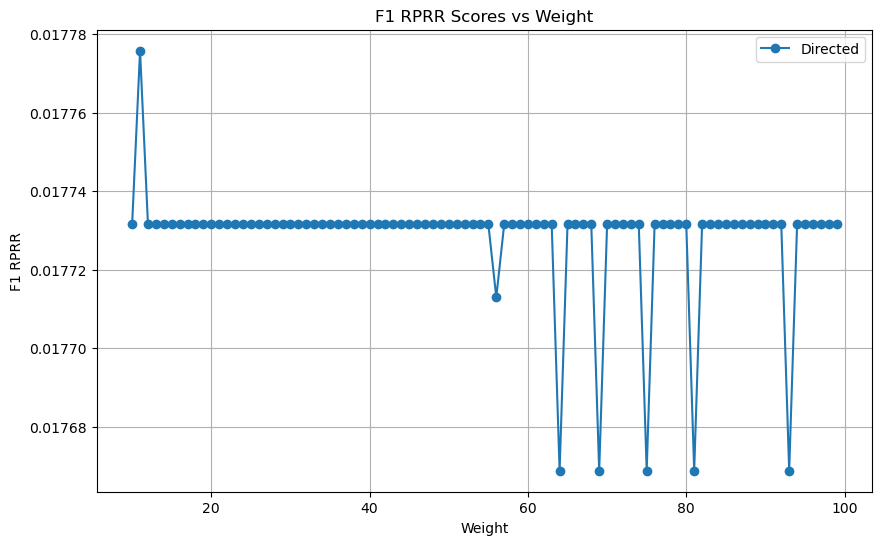

In [ ]:
plt.figure(figsize=(10, 6))

# Plot for directed scores
plt.plot(directed_scores_weight['weight'], directed_scores_weight['f1rprr'], marker='o', linestyle='-', label='Directed')
plt.xlabel('Weight')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Weight')
plt.legend()
plt.grid(True)
plt.show()

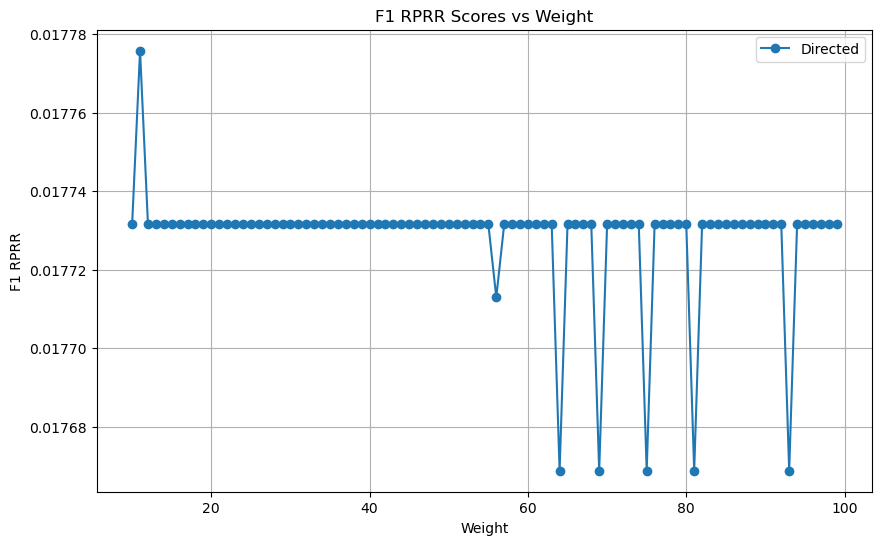

In [ ]:
plt.figure(figsize=(10, 6))

# Plot for undirected scores
plt.plot(undirected_scores_weight['weight'], undirected_scores_weight['f1rprr'], marker='o', linestyle='-', label='Undirected')
plt.xlabel('Weight')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Weight')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
max_undirected_score_weight = undirected_scores_weight.loc[undirected_scores_weight['f1rprr'].idxmax()]
max_directed_score_weight = directed_scores_weight.loc[directed_scores_weight['f1rprr'].idxmax()]

print("Weight with highest undirected F1rprr score:")
print(max_undirected_score_weight)
print("Weight with highest directed F1rprr score:")
print(max_directed_score_weight)

Weight with highest undirected F1rprr score:
weight       10.000000
precision     0.003289
recall        0.019756
recovery      0.141503
relevance     0.152012
f1rprr        0.010860
Name: 0, dtype: float64
Weight with highest directed F1rprr score:
weight       11.000000
precision     0.006872
recall        0.015014
recovery      0.169919
relevance     0.142654
f1rprr        0.017776
Name: 1, dtype: float64


In [ ]:
directed_list = []
undirected_list = []

louvain_community_undirected = nx.community.louvain_communities(ecoli_trn_undirected, weight='weight', resolution=1, threshold= 1e-7, seed=None)
louvain_community_directed = nx.community.louvain_communities(ecoli_trn_directed, weight='weight', resolution=1, threshold= 1e-7, seed=None)
louvain_directed_sets = [set(module) for module in louvain_community_directed]
louvain_undirected_sets = [set(module) for module in louvain_community_undirected]
ModulesB = Modules(known_modules)
ModulesA_directed = Modules(louvain_directed_sets)
ModulesA_undirected = Modules(louvain_undirected_sets)
undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)
direct_comp = ModulesComparison(ModulesA_directed, ModulesB, all_genes).score(None)
directed_list.append((direct_comp['precision'], direct_comp['recall'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rprr']))
undirected_list.append((undirect_comp['precision'], undirect_comp['recall'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rprr']))

directed_scores = pd.DataFrame(directed_list, columns=['precision', 'recall', 'recovery', 'relevance', 'f1rprr'])
undirected_scores = pd.DataFrame(undirected_list, columns=['precision', 'recall', 'recovery', 'relevance', 'f1rprr'])

In [ ]:
directed_scores 

,precision,recall,recovery,relevance,f1rprr
0,0.006864,0.01493,0.169733,0.142261,0.017732


In [ ]:
undirected_scores

,precision,recall,recovery,relevance,f1rprr
0,0.003289,0.019756,0.141503,0.152012,0.01086


Based on these results, it appears that weight and threshold have very little impact on the resulting scores. Therefore, we should move forward optimizing resolution and edge count. 

In [14]:
directed_list = []
undirected_list = []

for i in range (1000,10000,500):
    for j in range (10,100,5):
        ecoli_trn_undirected = nx.Graph()
        ecoli_trn_undirected.add_weighted_edges_from(
            [tuple(val) for val in genie3_undirected[['regulatoryGene', 'targetGene', 'weight']].head(i).values])
        ecoli_trn_directed = nx.Graph()
        ecoli_trn_directed.add_weighted_edges_from(
            [tuple(val) for val in genie3_directed[['regulatoryGene', 'targetGene', 'weight']].head(i).values])
        res = j/10
        louvain_community_undirected = nx.community.louvain_communities(ecoli_trn_undirected, weight='weight', resolution=res, threshold=1e-7, seed=None)
        louvain_community_directed = nx.community.louvain_communities(ecoli_trn_directed, weight='weight', resolution=res, threshold=1e-7, seed=None)
        louvain_directed_sets = [set(module) for module in louvain_community_directed]
        louvain_undirected_sets = [set(module) for module in louvain_community_undirected]
        ModulesB = Modules(known_modules)
        ModulesA_directed = Modules(louvain_directed_sets)
        ModulesA_undirected = Modules(louvain_undirected_sets)
        undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)
        direct_comp = ModulesComparison(ModulesA_directed, ModulesB, all_genes).score(None)

        directed_list.append((i, res, direct_comp['precision'], direct_comp['recall'], direct_comp['F1rp'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rr'], direct_comp['F1rprr']))
        undirected_list.append((i, res, undirect_comp['precision'], undirect_comp['recall'], undirect_comp['F1rp'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rr'], undirect_comp['F1rprr']))

directed_scores = pd.DataFrame(directed_list, columns=['edges', 'resolution', 'precision', 'recall', 'f1rp', 'recovery', 'relevance', 'f1rr', 'f1rprr'])
undirected_scores = pd.DataFrame(undirected_list, columns=['edges', 'resolution', 'precision', 'recall', 'f1rp', 'recovery', 'relevance', 'f1rr', 'f1rprr'])

In [15]:
directed_scores

,edges,resolution,precision,recall,f1rp,recovery,relevance,f1rr,f1rprr
0,1000,1.0,0.006872,0.015014,0.009428,0.169919,0.142654,0.155098,0.017776
1,1000,1.5,0.007037,0.015491,0.009677,0.175017,0.145996,0.159195,0.018246
2,1000,2.0,0.007037,0.015491,0.009677,0.175017,0.145996,0.159195,0.018246
3,1000,2.5,0.007037,0.015491,0.009677,0.175017,0.145996,0.159195,0.018246
4,1000,3.0,0.007038,0.015669,0.009713,0.174082,0.147556,0.159725,0.018312
...,...,...,...,...,...,...,...,...,...
319,9500,7.5,0.008008,0.012429,0.009741,0.102694,0.088643,0.095153,0.017672
320,9500,8.0,0.007984,0.012287,0.009679,0.102253,0.087409,0.094250,0.017555
321,9500,8.5,0.007949,0.012607,0.009750,0.104080,0.091196,0.097213,0.017723
322,9500,9.0,0.007916,0.012855,0.009799,0.101479,0.094723,0.097984,0.017816


In [17]:
undirected_scores

,edges,resolution,precision,recall,f1rp,recovery,relevance,f1rr,f1rprr
0,1000,1.0,0.003289,0.019756,0.005639,0.141503,0.152012,0.146569,0.010860
1,1000,1.5,0.003289,0.019756,0.005639,0.141503,0.152012,0.146569,0.010860
2,1000,2.0,0.003289,0.019756,0.005639,0.141503,0.152012,0.146569,0.010860
3,1000,2.5,0.003289,0.019756,0.005639,0.141503,0.152012,0.146569,0.010860
4,1000,3.0,0.003289,0.019756,0.005639,0.141503,0.152012,0.146569,0.010860
...,...,...,...,...,...,...,...,...,...
319,9500,7.5,0.010668,0.046339,0.017344,0.100123,0.287410,0.148511,0.031060
320,9500,8.0,0.010598,0.047095,0.017302,0.099471,0.288994,0.148001,0.030982
321,9500,8.5,0.010394,0.046500,0.016990,0.100620,0.292790,0.149770,0.030517
322,9500,9.0,0.010341,0.045613,0.016860,0.097646,0.286587,0.145662,0.030221


In [18]:
max_undirected_f1rp =  undirected_scores.loc[undirected_scores['f1rp'].idxmax()]
max_directed_f1rp = directed_scores.loc[directed_scores['f1rp'].idxmax()]
max_undirected_f1rr =  undirected_scores.loc[undirected_scores['f1rr'].idxmax()]
max_directed_f1rr = directed_scores.loc[directed_scores['f1rr'].idxmax()]
max_undirected_f1rprr = undirected_scores.loc[undirected_scores['f1rprr'].idxmax()]
max_directed_f1rprr = directed_scores.loc[directed_scores['f1rprr'].idxmax()]

print("Resolution and Edges with highest undirected F1rp score:")
print(max_undirected_f1rp)
print("Resolution and Edges directed F1rp score:")
print(max_directed_f1rp)
print("Resolution and Edges with highest undirected F1rr score:")
print(max_undirected_f1rr)
print("Resolution and Edges directed F1rr score:")
print(max_directed_f1rr)
print("Resolution and Edges with highest undirected F1rprr score:")
print(max_undirected_f1rprr)
print("Resolution and Edges directed F1rprr score:")
print(max_directed_f1rprr)

Resolution and Edges with highest undirected F1rp score:
edges         8500.000000
resolution       1.000000
precision        0.014404
recall           0.049354
f1rp             0.022300
recovery         0.104185
relevance        0.279167
f1rr             0.151741
f1rprr           0.038885
Name: 270, dtype: float64
Resolution and Edges directed F1rp score:
edges         1000.000000
resolution       7.500000
precision        0.007880
recall           0.018660
f1rp             0.011081
recovery         0.117058
relevance        0.157637
f1rr             0.134350
f1rprr           0.020474
Name: 13, dtype: float64
Resolution and Edges with highest undirected F1rr score:
edges         4000.000000
resolution       3.000000
precision        0.007998
recall           0.038110
f1rp             0.013221
recovery         0.137573
relevance        0.257699
f1rr             0.179382
f1rprr           0.024628
Name: 112, dtype: float64
Resolution and Edges directed F1rr score:
edges         1000.0000

In [17]:
directed_scores.to_csv('../results/directed_scores_unfiltered_louvain.csv', index=False)

In [18]:
undirected_scores.to_csv('../results/undirected_scores_unfiltered_louvain.csv', index=False)

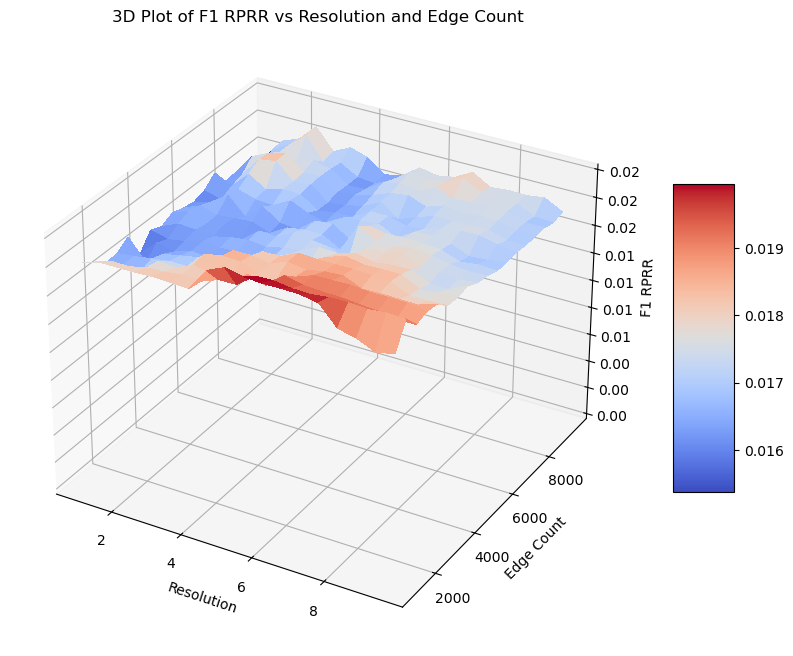

In [17]:
resolution_grid, edge_count_grid = np.meshgrid(sorted(directed_scores['resolution'].unique()), sorted(directed_scores['edges'].unique()))

f1rprr_grid_directed = directed_scores.pivot(index='edges', columns='resolution', values='f1rprr').values

# 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf_directed = ax.plot_surface(resolution_grid, edge_count_grid, f1rprr_grid_directed, cmap=cm.coolwarm, linewidth=0, antialiased=False, label='Directed')

# Customize the z axis
ax.set_zlim(0, 0.02)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

# Add labels and title
ax.set_xlabel('Resolution')
ax.set_ylabel('Edge Count')
ax.set_zlabel('F1 RPRR')
ax.set_title('3D Plot of F1 RPRR vs Resolution and Edge Count')

# Add a color bar which maps values to colors
fig.colorbar(surf_directed, shrink=0.5, aspect=5)

plt.show()

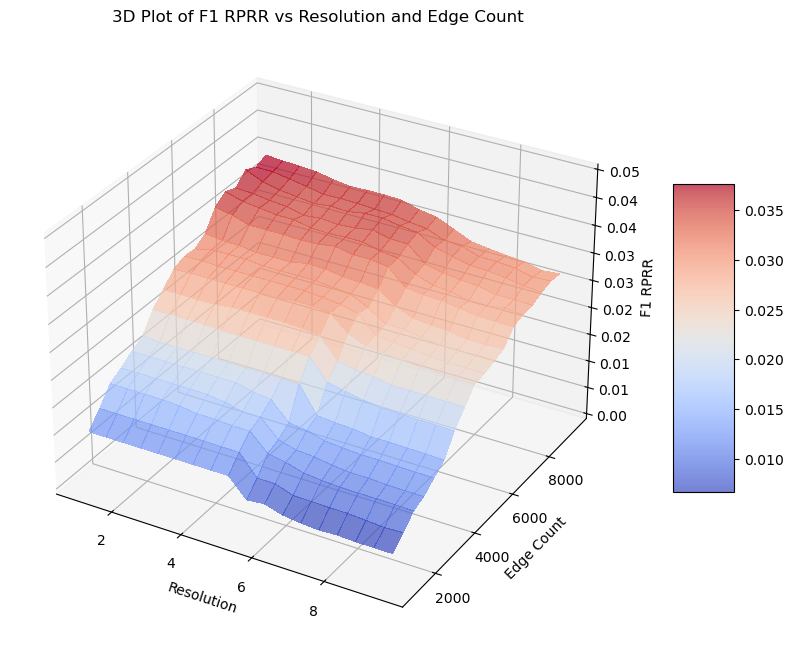

In [18]:
resolution_grid, edge_count_grid = np.meshgrid(sorted(undirected_scores['resolution'].unique()), sorted(undirected_scores['edges'].unique()))

f1rprr_grid_undirected = undirected_scores.pivot(index='edges', columns='resolution', values='f1rprr').values

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf_undirected = ax.plot_surface(resolution_grid, edge_count_grid, f1rprr_grid_undirected, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.7, label='Undirected')

# Customize the z axis
ax.set_zlim(0, 0.05)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

# Add labels and title
ax.set_xlabel('Resolution')
ax.set_ylabel('Edge Count')
ax.set_zlabel('F1 RPRR')
ax.set_title('3D Plot of F1 RPRR vs Resolution and Edge Count')

# Add a color bar which maps values to colors
fig.colorbar(surf_undirected, shrink=0.5, aspect=5)

plt.show()

In [19]:
directed_list = []
undirected_list = []

for i in range (10000,20000,500):
    for j in range (10,100,5):
        ecoli_trn_undirected = nx.graph()
        ecoli_trn_undirected.add_weighted_edges_from(
            [tuple(val) for val in genie3_undirected[['regulatoryGene', 'targetGene', 'weight']].head(i).values])
        res = j/10
        louvain_community_undirected = nx.community.louvain_communities(ecoli_trn_undirected, weight='weight', resolution=res, threshold=1e-7, seed=None)
        louvain_undirected_sets = [set(module) for module in louvain_community_undirected]
        ModulesB = Modules(known_modules)
        ModulesA_undirected = Modules(louvain_undirected_sets)
        undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)

        undirected_list.append((i, res, undirect_comp['precision'], undirect_comp['recall'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rprr']))

undirected_scores_higher_edges = pd.DataFrame(undirected_list, columns=['edges', 'resolution', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])

In [20]:
undirected_scores_higher_edges 

,edges,resolution,precision,recall,recovery,relevance,f1rprr
0,10000,1.0,0.014418,0.047255,0.098688,0.271522,0.038337
1,10000,1.5,0.014011,0.047198,0.098456,0.271281,0.037593
2,10000,2.0,0.013801,0.046844,0.098461,0.271138,0.037157
3,10000,2.5,0.013900,0.047101,0.099204,0.272602,0.037410
4,10000,3.0,0.013510,0.048691,0.099102,0.275014,0.036939
...,...,...,...,...,...,...,...
355,19500,7.5,0.014447,0.048441,0.101313,0.267802,0.038659
356,19500,8.0,0.014322,0.047333,0.099103,0.265891,0.038168
357,19500,8.5,0.013015,0.046955,0.099800,0.264464,0.035736
358,19500,9.0,0.013104,0.045833,0.099021,0.264115,0.035709


In [23]:
max_undirected_score_higher = undirected_scores_higher_edges.loc[undirected_scores_higher_edges['f1rprr'].idxmax()]

print("Resolution and Edges with highest undirected F1rprr score:")
print(max_undirected_score_higher)

Resolution and Edges with highest undirected F1rprr score:
edges         19500.000000
resolution        4.000000
precision         0.017350
recall            0.047009
recovery          0.102719
relevance         0.253734
f1rprr            0.043204
Name: 348, dtype: float64


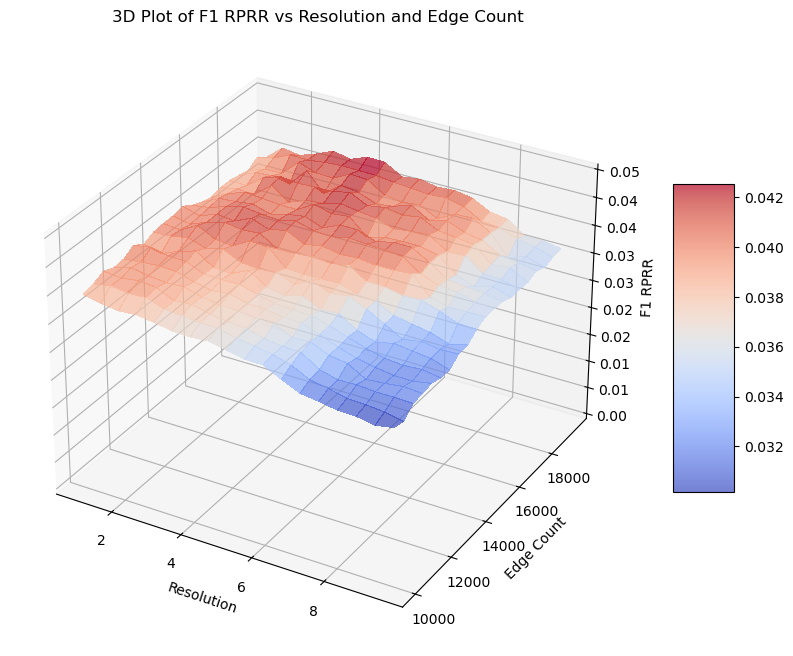

In [22]:
resolution_grid, edge_count_grid = np.meshgrid(sorted(undirected_scores_higher_edges['resolution'].unique()), sorted(undirected_scores_higher_edges['edges'].unique()))

f1rprr_grid_undirected = undirected_scores_higher_edges.pivot(index='edges', columns='resolution', values='f1rprr').values

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf_undirected = ax.plot_surface(resolution_grid, edge_count_grid, f1rprr_grid_undirected, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.7, label='Undirected')

# Customize the z axis
ax.set_zlim(0, 0.05)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

# Add labels and title
ax.set_xlabel('Resolution')
ax.set_ylabel('Edge Count')
ax.set_zlabel('F1 RPRR')
ax.set_title('3D Plot of F1 RPRR vs Resolution and Edge Count')

# Add a color bar which maps values to colors
fig.colorbar(surf_undirected, shrink=0.5, aspect=5)

plt.show()

In [20]:
import igraph as ig

from igraph import Graph

import leidenalg

directed_list_leiden = []
undirected_list_leiden = []

for i in range (1000,10000,500):
    for j in range (1,20,1):

        graph_undirected = Graph.TupleList(genie3_undirected[['regulatoryGene', 'targetGene', 'weight']].head(int(i)).itertuples(index=False))
        graph_directed = Graph.TupleList(genie3_directed[['regulatoryGene', 'targetGene', 'weight']].head(int(i)).itertuples(index=False))

        partitions_undirected = leidenalg.find_partition(graph_undirected, leidenalg.ModularityVertexPartition, n_iterations=j)
        partitions_directed = leidenalg.find_partition(graph_directed, leidenalg.ModularityVertexPartition, n_iterations=j)

        modules_undirected = [subgraph.vs['name'] for subgraph in partitions_undirected.subgraphs()]
        modules_directed = [subgraph.vs['name'] for subgraph in partitions_directed.subgraphs()]

        predicted_undirected = Modules(modules_undirected).filter_size(5)
        predicted_directed = Modules(modules_directed).filter_size(5)

        [len(module) for module in predicted_undirected]

        leiden_undirected_sets = [set(module) for module in predicted_undirected]
        leiden_directed_sets = [set(module) for module in predicted_directed]
        ModulesB = Modules(known_modules)
        ModulesA_undirected = Modules(leiden_undirected_sets)
        ModulesA_directed = Modules(leiden_directed_sets)
        undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)
        direct_comp = ModulesComparison(ModulesA_directed, ModulesB, all_genes).score(None)

        undirected_list_leiden.append((i, j, undirect_comp['precision'], undirect_comp['recall'], undirect_comp['F1rp'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rr'], undirect_comp['F1rprr']))
        directed_list_leiden.append((i, j, direct_comp['precision'], direct_comp['recall'], direct_comp['F1rp'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rr'], direct_comp['F1rprr']))

undirected_scores_leiden = pd.DataFrame(undirected_list_leiden, columns=['edges', 'iterations', 'precision', 'recall', 'f1rp', 'recovery', 'relevance', 'f1rr', 'f1rprr'])
directed_scores_leiden = pd.DataFrame(directed_list_leiden, columns=['edges', 'iterations', 'precision', 'recall', 'f1rp', 'recovery', 'relevance', 'f1rr', 'f1rprr'])

In [21]:
undirected_scores_leiden

,edges,iterations,precision,recall,f1rp,recovery,relevance,f1rr,f1rprr
0,1000,1,0.003113,0.015268,0.005171,0.330281,0.101531,0.155317,0.010009
1,1000,2,0.003113,0.015268,0.005171,0.330281,0.101531,0.155317,0.010009
2,1000,3,0.003113,0.015268,0.005171,0.330281,0.101531,0.155317,0.010009
3,1000,4,0.003113,0.015268,0.005171,0.330281,0.101531,0.155317,0.010009
4,1000,5,0.003113,0.015268,0.005171,0.330281,0.101531,0.155317,0.010009
...,...,...,...,...,...,...,...,...,...
337,9500,15,0.012740,0.039969,0.019321,0.259411,0.196334,0.223508,0.035567
338,9500,16,0.012740,0.039969,0.019321,0.259411,0.196334,0.223508,0.035567
339,9500,17,0.012740,0.039969,0.019321,0.259411,0.196334,0.223508,0.035567
340,9500,18,0.012740,0.039969,0.019321,0.259411,0.196334,0.223508,0.035567


In [22]:
directed_scores_leiden

,edges,iterations,precision,recall,f1rp,recovery,relevance,f1rr,f1rprr
0,1000,1,0.006560,0.013258,0.008777,0.229052,0.119350,0.156930,0.016625
1,1000,2,0.006577,0.013360,0.008814,0.229571,0.119797,0.157438,0.016694
2,1000,3,0.006577,0.013360,0.008814,0.229571,0.119797,0.157438,0.016694
3,1000,4,0.006577,0.013360,0.008814,0.229571,0.119797,0.157438,0.016694
4,1000,5,0.006577,0.013360,0.008814,0.229571,0.119797,0.157438,0.016694
...,...,...,...,...,...,...,...,...,...
337,9500,15,0.006447,0.005613,0.006001,0.085748,0.029225,0.043592,0.010550
338,9500,16,0.006484,0.005903,0.006180,0.105515,0.031200,0.048160,0.010955
339,9500,17,0.006232,0.005838,0.006028,0.101526,0.032138,0.048821,0.010732
340,9500,18,0.006397,0.005368,0.005838,0.089064,0.028275,0.042924,0.010277


In [25]:
max_undirected_f1rp_leiden =  undirected_scores_leiden.loc[undirected_scores_leiden['f1rp'].idxmax()]
max_directed_f1rp_leiden = directed_scores_leiden.loc[directed_scores_leiden['f1rp'].idxmax()]
max_undirected_f1rr_leiden =  undirected_scores_leiden.loc[undirected_scores_leiden['f1rr'].idxmax()]
max_directed_f1rr_leiden = directed_scores_leiden.loc[directed_scores_leiden['f1rr'].idxmax()]
max_undirected_f1rprr_leiden = undirected_scores_leiden.loc[undirected_scores_leiden['f1rprr'].idxmax()]
max_directed_f1rprr_leiden = directed_scores_leiden.loc[directed_scores_leiden['f1rprr'].idxmax()]

print("Resolution and Edges with highest undirected F1rp score:")
print(max_undirected_f1rp_leiden)
print("Resolution and Edges directed F1rp score:")
print(max_directed_f1rp_leiden)
print("Resolution and Edges with highest undirected F1rr score:")
print(max_undirected_f1rr_leiden)
print("Resolution and Edges directed F1rr score:")
print(max_directed_f1rr_leiden)
print("Resolution and Edges with highest undirected F1rprr score:")
print(max_undirected_f1rprr_leiden)
print("Resolution and Edges directed F1rprr score:")
print(max_directed_f1rprr_leiden)

Resolution and Edges with highest undirected F1rp score:
edges         8500.000000
iterations       1.000000
precision        0.012932
recall           0.039942
f1rp             0.019538
recovery         0.266189
relevance        0.194413
f1rr             0.224708
f1rprr           0.035950
Name: 285, dtype: float64
Resolution and Edges directed F1rp score:
edges         5500.000000
iterations       1.000000
precision        0.007974
recall           0.010139
f1rp             0.008927
recovery         0.152785
relevance        0.050077
f1rr             0.075431
f1rprr           0.015965
Name: 171, dtype: float64
Resolution and Edges with highest undirected F1rr score:
edges         8500.000000
iterations       1.000000
precision        0.012932
recall           0.039942
f1rp             0.019538
recovery         0.266189
relevance        0.194413
f1rr             0.224708
f1rprr           0.035950
Name: 285, dtype: float64
Resolution and Edges directed F1rr score:
edges         1000.000

In [26]:
directed_scores_leiden.to_csv('../results/directed_scores_filtered_leiden.csv', index=False)

In [27]:
undirected_scores_leiden.to_csv('../results/undirected_scores_filtered_leiden.csv', index=False)

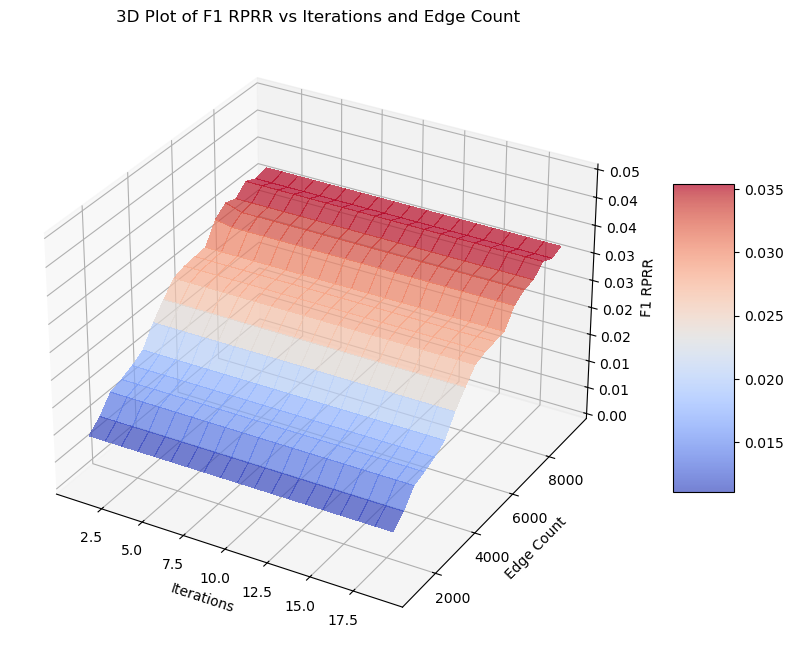

In [27]:
resolution_grid, edge_count_grid = np.meshgrid(sorted(undirected_scores_leiden['iterations'].unique()), sorted(undirected_scores_leiden['edges'].unique()))

f1rprr_grid_undirected = undirected_scores_leiden.pivot(index='edges', columns='iterations', values='f1rprr').values

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf_undirected = ax.plot_surface(resolution_grid, edge_count_grid, f1rprr_grid_undirected, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.7, label='Undirected')

# Customize the z axis
ax.set_zlim(0, 0.05)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

# Add labels and title
ax.set_xlabel('Iterations')
ax.set_ylabel('Edge Count')
ax.set_zlabel('F1 RPRR')
ax.set_title('3D Plot of F1 RPRR vs Iterations and Edge Count')

# Add a color bar which maps values to colors
fig.colorbar(surf_undirected, shrink=0.5, aspect=5)

plt.show()

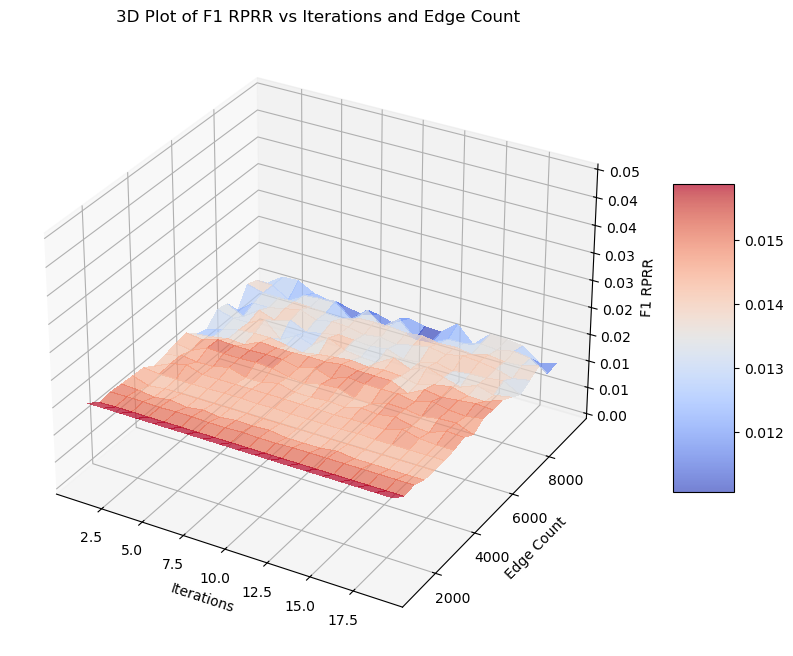

In [28]:
resolution_grid, edge_count_grid = np.meshgrid(sorted(directed_scores_leiden['iterations'].unique()), sorted(directed_scores_leiden['edges'].unique()))

f1rprr_grid_directed = directed_scores_leiden.pivot(index='edges', columns='iterations', values='f1rprr').values

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf_directed = ax.plot_surface(resolution_grid, edge_count_grid, f1rprr_grid_directed, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.7, label='Directed')

# Customize the z axis
ax.set_zlim(0, 0.05)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

# Add labels and title
ax.set_xlabel('Iterations')
ax.set_ylabel('Edge Count')
ax.set_zlabel('F1 RPRR')
ax.set_title('3D Plot of F1 RPRR vs Iterations and Edge Count')

# Add a color bar which maps values to colors
fig.colorbar(surf_directed, shrink=0.5, aspect=5)

plt.show()

In [28]:
directed_list = []
undirected_list = []

for i in range (1000,10000,500):
    for j in range (10,100,5):
        ecoli_trn_undirected = nx.Graph()
        ecoli_trn_undirected.add_weighted_edges_from(
            [tuple(val) for val in genie3_undirected[['regulatoryGene', 'targetGene', 'weight']].head(i).values])
        ecoli_trn_directed = nx.Graph()
        ecoli_trn_directed.add_weighted_edges_from(
            [tuple(val) for val in genie3_directed[['regulatoryGene', 'targetGene', 'weight']].head(i).values])
        res = j/10
        louvain_community_undirected = nx.community.louvain_communities(ecoli_trn_undirected, weight='weight', resolution=res, threshold=1e-7, seed=None)
        louvain_community_directed = nx.community.louvain_communities(ecoli_trn_directed, weight='weight', resolution=res, threshold=1e-7, seed=None)
        louvain_predicted_directed = Modules(louvain_community_directed).filter_size(5)
        louvain_predicted_undirected = Modules(louvain_community_undirected).filter_size(5)
        louvain_directed_sets = [set(module) for module in louvain_predicted_directed]
        louvain_undirected_sets = [set(module) for module in louvain_predicted_undirected]
        ModulesB = Modules(known_modules)
        ModulesA_directed = Modules(louvain_directed_sets)
        ModulesA_undirected = Modules(louvain_undirected_sets)
        undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)
        direct_comp = ModulesComparison(ModulesA_directed, ModulesB, all_genes).score(None)

        directed_list.append((i, res, direct_comp['precision'], direct_comp['recall'], direct_comp['F1rp'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rr'], direct_comp['F1rprr']))
        undirected_list.append((i, res, undirect_comp['precision'], undirect_comp['recall'], undirect_comp['F1rp'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rr'], undirect_comp['F1rprr']))

directed_filtered_scores = pd.DataFrame(directed_list, columns=['edges', 'resolution', 'precision', 'recall', 'f1rp', 'recovery', 'relevance', 'f1rr', 'f1rprr'])
undirected_filtered_scores = pd.DataFrame(undirected_list, columns=['edges', 'resolution', 'precision', 'recall', 'f1rp', 'recovery', 'relevance', 'f1rr', 'f1rprr'])

In [29]:
directed_filtered_scores

,edges,resolution,precision,recall,f1rp,recovery,relevance,f1rr,f1rprr
0,1000,1.0,0.006577,0.013360,0.008814,0.229571,0.119797,0.157438,0.016694
1,1000,1.5,0.006742,0.013837,0.009066,0.237678,0.123672,0.162691,0.017176
2,1000,2.0,0.006742,0.013837,0.009066,0.237678,0.123672,0.162691,0.017176
3,1000,2.5,0.006742,0.013837,0.009066,0.237678,0.123672,0.162691,0.017176
4,1000,3.0,0.006742,0.013956,0.009091,0.235876,0.125271,0.163637,0.017226
...,...,...,...,...,...,...,...,...,...
319,9500,7.5,0.008000,0.012269,0.009685,0.102584,0.088396,0.094963,0.017578
320,9500,8.0,0.007861,0.012254,0.009577,0.103581,0.089099,0.095796,0.017414
321,9500,8.5,0.007858,0.012523,0.009657,0.102200,0.091566,0.096591,0.017559
322,9500,9.0,0.007803,0.012765,0.009686,0.100817,0.095129,0.097890,0.017628


In [30]:
undirected_filtered_scores

,edges,resolution,precision,recall,f1rp,recovery,relevance,f1rr,f1rprr
0,1000,1.0,0.003113,0.015268,0.005171,0.330281,0.101531,0.155317,0.010009
1,1000,1.5,0.003113,0.015268,0.005171,0.330281,0.101531,0.155317,0.010009
2,1000,2.0,0.003113,0.015268,0.005171,0.330281,0.101531,0.155317,0.010009
3,1000,2.5,0.003113,0.015268,0.005171,0.330281,0.101531,0.155317,0.010009
4,1000,3.0,0.003113,0.015268,0.005171,0.330281,0.101531,0.155317,0.010009
...,...,...,...,...,...,...,...,...,...
319,9500,7.5,0.009258,0.037571,0.014856,0.238808,0.205955,0.221168,0.027842
320,9500,8.0,0.009195,0.039275,0.014902,0.248266,0.212223,0.228834,0.027982
321,9500,8.5,0.009038,0.036801,0.014512,0.239710,0.208266,0.222884,0.027250
322,9500,9.0,0.008695,0.035886,0.013998,0.232303,0.207887,0.219418,0.026317


In [31]:
directed_filtered_scores.to_csv('../results/directed_scores_filtered_louvain.csv', index=False)

In [32]:
undirected_filtered_scores.to_csv('../results/undirected_scores_filtered_louvain.csv', index=False)

In [33]:
max_undirected_filtered_f1rp =  undirected_filtered_scores.loc[undirected_filtered_scores['f1rp'].idxmax()]
max_directed_filtered_f1rp = directed_filtered_scores.loc[directed_filtered_scores['f1rp'].idxmax()]
max_undirected_filtered_f1rr =  undirected_filtered_scores.loc[undirected_filtered_scores['f1rr'].idxmax()]
max_directed_filtered_f1rr = directed_filtered_scores.loc[directed_filtered_scores['f1rr'].idxmax()]
max_undirected_filtered_f1rprr = undirected_filtered_scores.loc[undirected_filtered_scores['f1rprr'].idxmax()]
max_directed_filtered_f1rprr = directed_filtered_scores.loc[directed_filtered_scores['f1rprr'].idxmax()]

print("Resolution and Edges with highest undirected F1rp score:")
print(max_undirected_filtered_f1rp)
print("Resolution and Edges directed F1rp score:")
print(max_directed_filtered_f1rp)
print("Resolution and Edges with highest undirected F1rr score:")
print(max_undirected_filtered_f1rr)
print("Resolution and Edges directed F1rr score:")
print(max_directed_filtered_f1rr)
print("Resolution and Edges with highest undirected F1rprr score:")
print(max_undirected_filtered_f1rprr)
print("Resolution and Edges directed F1rprr score:")
print(max_directed_filtered_f1rprr)

Resolution and Edges with highest undirected F1rp score:
edges         8500.000000
resolution       1.000000
precision        0.013184
recall           0.040661
f1rp             0.019912
recovery         0.268047
relevance        0.195408
f1rr             0.226035
f1rprr           0.036599
Name: 270, dtype: float64
Resolution and Edges directed F1rp score:
edges         8000.000000
resolution       2.500000
precision        0.009448
recall           0.012379
f1rp             0.010717
recovery         0.131057
relevance        0.060992
f1rr             0.083243
f1rprr           0.018989
Name: 255, dtype: float64
Resolution and Edges with highest undirected F1rr score:
edges         8500.000000
resolution       5.500000
precision        0.010809
recall           0.041045
f1rp             0.017111
recovery         0.254722
relevance        0.213493
f1rr             0.232292
f1rprr           0.031874
Name: 279, dtype: float64
Resolution and Edges directed F1rr score:
edges         1000.000

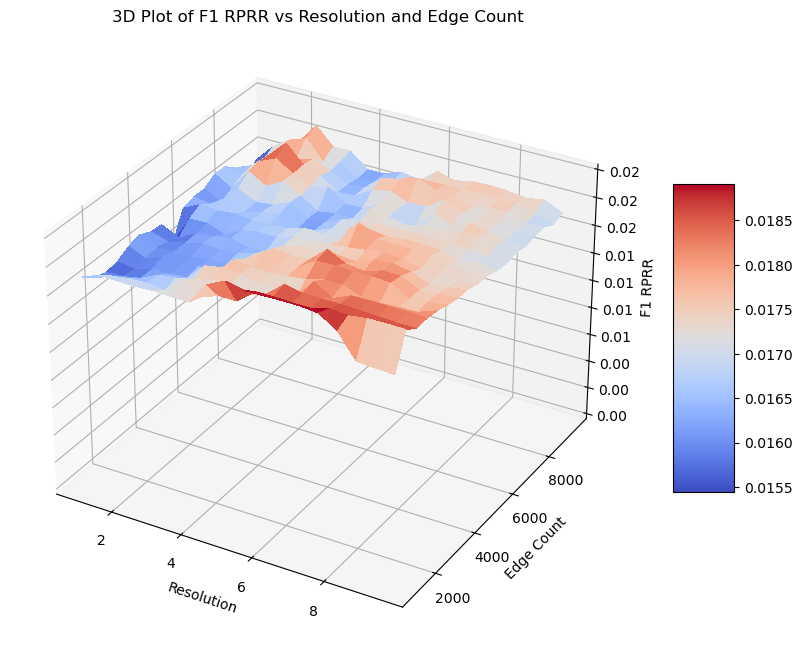

In [20]:
resolution_grid, edge_count_grid = np.meshgrid(sorted(directed_filtered_scores['resolution'].unique()), sorted(directed_filtered_scores['edges'].unique()))

f1rprr_grid_directed_filtered = directed_filtered_scores.pivot(index='edges', columns='resolution', values='f1rprr').values

# 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf_directed = ax.plot_surface(resolution_grid, edge_count_grid, f1rprr_grid_directed_filtered, cmap=cm.coolwarm, linewidth=0, antialiased=False, label='Directed')

# Customize the z axis
ax.set_zlim(0, 0.02)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

# Add labels and title
ax.set_xlabel('Resolution')
ax.set_ylabel('Edge Count')
ax.set_zlabel('F1 RPRR')
ax.set_title('3D Plot of F1 RPRR vs Resolution and Edge Count')

# Add a color bar which maps values to colors
fig.colorbar(surf_directed, shrink=0.5, aspect=5)

plt.show()

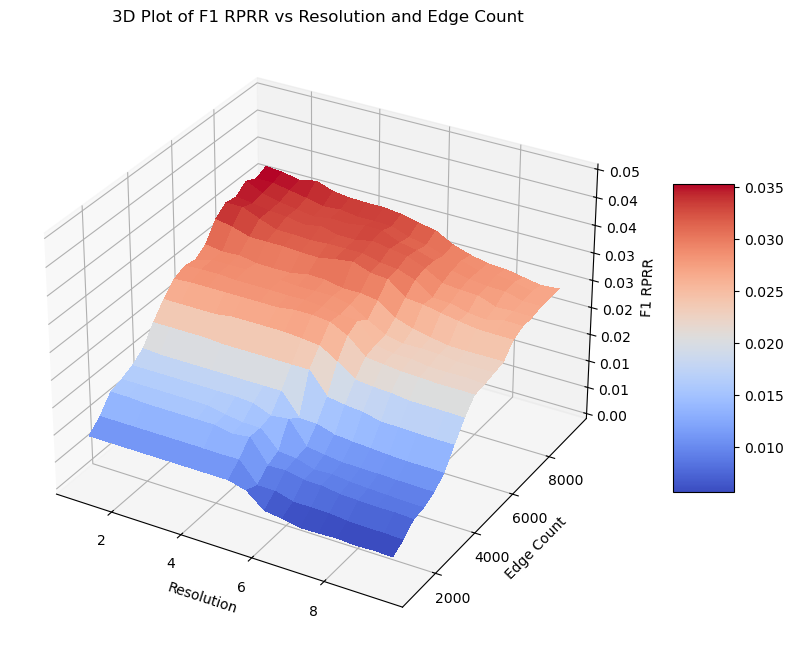

In [19]:
resolution_grid, edge_count_grid = np.meshgrid(sorted(undirected_filtered_scores['resolution'].unique()), sorted(undirected_filtered_scores['edges'].unique()))

f1rprr_grid_undirected_filtered = undirected_filtered_scores.pivot(index='edges', columns='resolution', values='f1rprr').values

# 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf_undirected = ax.plot_surface(resolution_grid, edge_count_grid, f1rprr_grid_undirected_filtered, cmap=cm.coolwarm, linewidth=0, antialiased=False, label='Directed')

# Customize the z axis
ax.set_zlim(0, 0.05)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

# Add labels and title
ax.set_xlabel('Resolution')
ax.set_ylabel('Edge Count')
ax.set_zlabel('F1 RPRR')
ax.set_title('3D Plot of F1 RPRR vs Resolution and Edge Count')

# Add a color bar which maps values to colors
fig.colorbar(surf_undirected, shrink=0.5, aspect=5)

plt.show()

In [34]:
import igraph as ig

from igraph import Graph

import leidenalg

directed_list_leiden = []
undirected_list_leiden = []

for i in range (1000,10000,500):
    for j in range (1,20,1):

        graph_undirected = Graph.TupleList(genie3_undirected[['regulatoryGene', 'targetGene', 'weight']].head(int(i)).itertuples(index=False))
        graph_directed = Graph.TupleList(genie3_directed[['regulatoryGene', 'targetGene', 'weight']].head(int(i)).itertuples(index=False))

        partitions_undirected = leidenalg.find_partition(graph_undirected, leidenalg.ModularityVertexPartition, n_iterations=j)
        partitions_directed = leidenalg.find_partition(graph_directed, leidenalg.ModularityVertexPartition, n_iterations=j)

        modules_undirected = [subgraph.vs['name'] for subgraph in partitions_undirected.subgraphs()]
        modules_directed = [subgraph.vs['name'] for subgraph in partitions_directed.subgraphs()]
        leiden_undirected_sets = [set(module) for module in modules_undirected]
        leiden_directed_sets = [set(module) for module in modules_directed]
        ModulesB = Modules(known_modules)
        ModulesA_undirected = Modules(leiden_undirected_sets)
        ModulesA_directed = Modules(leiden_directed_sets)
        undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)
        direct_comp = ModulesComparison(ModulesA_directed, ModulesB, all_genes).score(None)

        undirected_list_leiden.append((i, j, undirect_comp['precision'], undirect_comp['recall'], undirect_comp['F1rp'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rr'], undirect_comp['F1rprr']))
        directed_list_leiden.append((i, j, direct_comp['precision'], direct_comp['recall'], direct_comp['F1rp'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rr'], direct_comp['F1rprr']))

undirected_scores_leiden_unfiltered = pd.DataFrame(undirected_list_leiden, columns=['edges', 'iterations', 'precision', 'recall', 'f1rp', 'recovery', 'relevance', 'f1rr', 'f1rprr'])
directed_scores_leiden_unfiltered = pd.DataFrame(directed_list_leiden, columns=['edges', 'iterations', 'precision', 'recall', 'f1rp', 'recovery', 'relevance', 'f1rr', 'f1rprr'])

In [35]:
directed_scores_leiden_unfiltered

,edges,iterations,precision,recall,f1rp,recovery,relevance,f1rr,f1rprr
0,1000,1,0.006832,0.014902,0.009369,0.169820,0.142186,0.154780,0.017669
1,1000,2,0.006872,0.015014,0.009428,0.169919,0.142654,0.155098,0.017776
2,1000,3,0.006872,0.015014,0.009428,0.169919,0.142654,0.155098,0.017776
3,1000,4,0.006872,0.015014,0.009428,0.169919,0.142654,0.155098,0.017776
4,1000,5,0.006872,0.015014,0.009428,0.169919,0.142654,0.155098,0.017776
...,...,...,...,...,...,...,...,...,...
337,9500,15,0.006504,0.005509,0.005965,0.085671,0.028930,0.043254,0.010485
338,9500,16,0.006912,0.005872,0.006350,0.088427,0.029642,0.044400,0.011111
339,9500,17,0.006827,0.005601,0.006153,0.092006,0.028451,0.043462,0.010780
340,9500,18,0.008384,0.008591,0.008486,0.153999,0.040141,0.063682,0.014976


In [36]:
undirected_scores_leiden_unfiltered

,edges,iterations,precision,recall,f1rp,recovery,relevance,f1rr,f1rprr
0,1000,1,0.003289,0.019756,0.005639,0.141503,0.152012,0.146569,0.010860
1,1000,2,0.003289,0.019756,0.005639,0.141503,0.152012,0.146569,0.010860
2,1000,3,0.003289,0.019756,0.005639,0.141503,0.152012,0.146569,0.010860
3,1000,4,0.003289,0.019756,0.005639,0.141503,0.152012,0.146569,0.010860
4,1000,5,0.003289,0.019756,0.005639,0.141503,0.152012,0.146569,0.010860
...,...,...,...,...,...,...,...,...,...
337,9500,15,0.014066,0.048188,0.021775,0.100097,0.276606,0.146999,0.037932
338,9500,16,0.014066,0.048188,0.021775,0.100097,0.276606,0.146999,0.037932
339,9500,17,0.014066,0.048188,0.021775,0.100097,0.276606,0.146999,0.037932
340,9500,18,0.014066,0.048188,0.021775,0.100097,0.276606,0.146999,0.037932


In [37]:
directed_scores_leiden_unfiltered.to_csv('../results/directed_scores_unfiltered_leiden.csv', index=False)

In [38]:
undirected_scores_leiden_unfiltered.to_csv('../results/undirected_scores_unfiltered_leiden.csv', index=False)

In [39]:
max_undirected_unfiltered_leiden_f1rp =  undirected_scores_leiden_unfiltered.loc[undirected_scores_leiden_unfiltered['f1rp'].idxmax()]
max_directed_unfiltered_leiden_f1rp = directed_scores_leiden_unfiltered.loc[directed_scores_leiden_unfiltered['f1rp'].idxmax()]
max_undirected_unfiltered_leiden_f1rr =  undirected_scores_leiden_unfiltered.loc[undirected_scores_leiden_unfiltered['f1rr'].idxmax()]
max_directed_unfiltered_leiden_f1rr = directed_scores_leiden_unfiltered.loc[directed_scores_leiden_unfiltered['f1rr'].idxmax()]
max_undirected_unfiltered_leiden_f1rprr = undirected_scores_leiden_unfiltered.loc[undirected_scores_leiden_unfiltered['f1rprr'].idxmax()]
max_directed_unfiltered_leiden_f1rprr = directed_scores_leiden_unfiltered.loc[directed_scores_leiden_unfiltered['f1rprr'].idxmax()]

print("Resolution and Edges with highest undirected F1rp score:")
print(max_undirected_unfiltered_leiden_f1rp)
print("Resolution and Edges directed F1rp score:")
print(max_directed_unfiltered_leiden_f1rp)
print("Resolution and Edges with highest undirected F1rr score:")
print(max_undirected_unfiltered_leiden_f1rr)
print("Resolution and Edges directed F1rr score:")
print(max_directed_unfiltered_leiden_f1rr)
print("Resolution and Edges with highest undirected F1rprr score:")
print(max_undirected_unfiltered_leiden_f1rprr)
print("Resolution and Edges directed F1rprr score:")
print(max_directed_unfiltered_leiden_f1rprr)

Resolution and Edges with highest undirected F1rp score:
edges         8500.000000
iterations       1.000000
precision        0.014152
recall           0.048635
f1rp             0.021925
recovery         0.104285
relevance        0.278163
f1rr             0.151698
f1rprr           0.038312
Name: 285, dtype: float64
Resolution and Edges directed F1rp score:
edges         1000.000000
iterations       2.000000
precision        0.006872
recall           0.015014
f1rp             0.009428
recovery         0.169919
relevance        0.142654
f1rr             0.155098
f1rprr           0.017776
Name: 1, dtype: float64
Resolution and Edges with highest undirected F1rr score:
edges         4000.000000
iterations       1.000000
precision        0.008098
recall           0.038046
f1rp             0.013354
recovery         0.136329
relevance        0.256194
f1rr             0.177960
f1rprr           0.024844
Name: 114, dtype: float64
Resolution and Edges directed F1rr score:
edges         1000.00000

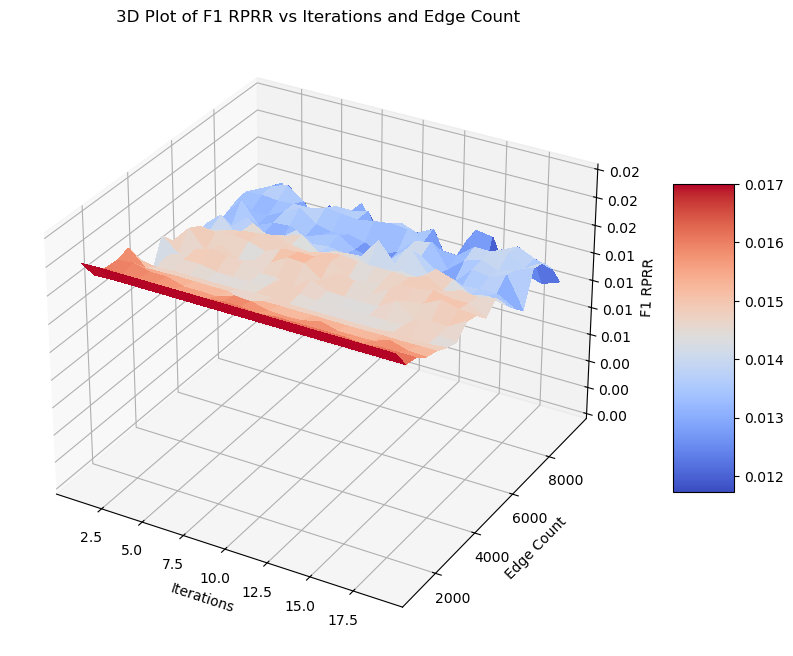

In [30]:
resolution_grid, edge_count_grid = np.meshgrid(sorted(directed_scores_leiden_unfiltered['iterations'].unique()), sorted(directed_scores_leiden_unfiltered['edges'].unique()))

f1rprr_grid_directed_filtered = directed_scores_leiden_unfiltered.pivot(index='edges', columns='iterations', values='f1rprr').values

# 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf_directed = ax.plot_surface(resolution_grid, edge_count_grid, f1rprr_grid_directed_filtered, cmap=cm.coolwarm, linewidth=0, antialiased=False, label='Directed')

# Customize the z axis
ax.set_zlim(0, 0.02)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

# Add labels and title
ax.set_xlabel('Iterations')
ax.set_ylabel('Edge Count')
ax.set_zlabel('F1 RPRR')
ax.set_title('3D Plot of F1 RPRR vs Iterations and Edge Count')

# Add a color bar which maps values to colors
fig.colorbar(surf_directed, shrink=0.5, aspect=5)

plt.show()

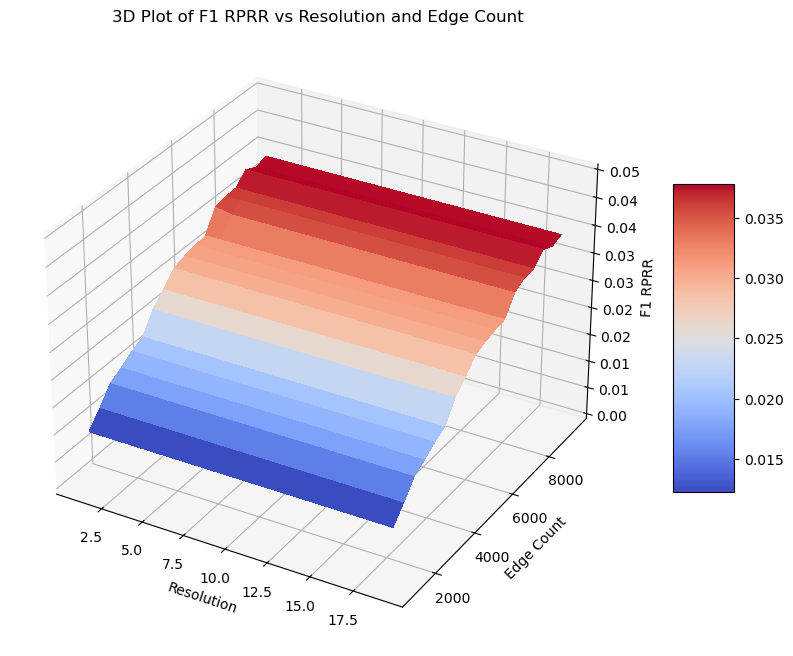

In [34]:
resolution_grid, edge_count_grid = np.meshgrid(sorted(undirected_scores_leiden_unfiltered['iterations'].unique()), sorted(undirected_scores_leiden_unfiltered['edges'].unique()))

f1rprr_grid_undirected_filtered = undirected_scores_leiden_unfiltered.pivot(index='edges', columns='iterations', values='f1rprr').values

# 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf_undirected = ax.plot_surface(resolution_grid, edge_count_grid, f1rprr_grid_undirected_filtered, cmap=cm.coolwarm, linewidth=0, antialiased=False, label='Undirected')

# Customize the z axis
ax.set_zlim(0, 0.05)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

# Add labels and title
ax.set_xlabel('Resolution')
ax.set_ylabel('Edge Count')
ax.set_zlabel('F1 RPRR')
ax.set_title('3D Plot of F1 RPRR vs Resolution and Edge Count')

# Add a color bar which maps values to colors
fig.colorbar(surf_undirected, shrink=0.5, aspect=5)

plt.show()

In [33]:
directed_list = []
undirected_list = []

for i in range (1000,10000,500):
    for j in range (10,100,5):
        ecoli_trn_undirected = nx.Graph()
        ecoli_trn_undirected.add_weighted_edges_from(
            [tuple(val) for val in genie3_undirected[['regulatoryGene', 'targetGene', 'weight']].head(i).values])
        ecoli_trn_directed = nx.Graph()
        ecoli_trn_directed.add_weighted_edges_from(
            [tuple(val) for val in genie3_directed[['regulatoryGene', 'targetGene', 'weight']].head(i).values])
        res = j/10
        louvain_community_undirected = nx.community.louvain_communities(ecoli_trn_undirected, weight='weight', resolution=res, threshold=1e-7, seed=None)
        louvain_community_directed = nx.community.louvain_communities(ecoli_trn_directed, weight='weight', resolution=res, threshold=1e-7, seed=None)
        louvain_predicted_directed = Modules(louvain_community_directed).filter_retaingenes(all_genes).filter_size(5)
        louvain_predicted_undirected = Modules(louvain_community_undirected).filter_retaingenes(all_genes).filter_size(5)
        louvain_directed_sets = [set(module) for module in louvain_predicted_directed]
        louvain_undirected_sets = [set(module) for module in louvain_predicted_undirected]
        ModulesB = Modules(known_modules)
        ModulesA_directed = Modules(louvain_directed_sets)
        ModulesA_undirected = Modules(louvain_undirected_sets)
        undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)
        direct_comp = ModulesComparison(ModulesA_directed, ModulesB, all_genes).score(None)

        directed_list.append((i, res, direct_comp['precision'], direct_comp['recall'], direct_comp['F1rp'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rr'], direct_comp['F1rprr']))
        undirected_list.append((i, res, undirect_comp['precision'], undirect_comp['recall'], undirect_comp['F1rp'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rr'], undirect_comp['F1rprr']))

directed_filtered_scores = pd.DataFrame(directed_list, columns=['edges', 'resolution', 'precision', 'recall', 'f1rp', 'recovery', 'relevance', 'f1rr', 'f1rprr'])
undirected_filtered_scores = pd.DataFrame(undirected_list, columns=['edges', 'resolution', 'precision', 'recall', 'f1rp', 'recovery', 'relevance', 'f1rr', 'f1rprr'])

In [34]:
directed_filtered_scores

,edges,resolution,precision,recall,recovery,relevance,f1rprr
0,1000,1.0,0.006577,0.013360,0.229571,0.119797,0.016694
1,1000,1.5,0.006742,0.013837,0.237678,0.123672,0.017176
2,1000,2.0,0.006742,0.013837,0.237678,0.123672,0.017176
3,1000,2.5,0.006742,0.013837,0.237678,0.123672,0.017176
4,1000,3.0,0.006720,0.013867,0.234760,0.124938,0.017153
...,...,...,...,...,...,...,...
319,9500,7.5,0.008025,0.012303,0.104435,0.087872,0.017634
320,9500,8.0,0.007938,0.012265,0.102532,0.088061,0.017497
321,9500,8.5,0.007830,0.012452,0.103327,0.090622,0.017487
322,9500,9.0,0.007914,0.012759,0.101489,0.093332,0.017754


In [35]:
undirected_filtered_scores

,edges,resolution,precision,recall,recovery,relevance,f1rprr
0,1000,1.0,0.003113,0.015268,0.330281,0.101531,0.010009
1,1000,1.5,0.003113,0.015268,0.330281,0.101531,0.010009
2,1000,2.0,0.003113,0.015268,0.330281,0.101531,0.010009
3,1000,2.5,0.003113,0.015268,0.330281,0.101531,0.010009
4,1000,3.0,0.003113,0.015268,0.330281,0.101531,0.010009
...,...,...,...,...,...,...,...
319,9500,7.5,0.009366,0.037569,0.240715,0.204983,0.028086
320,9500,8.0,0.009192,0.039116,0.248094,0.212024,0.027951
321,9500,8.5,0.009043,0.037024,0.235819,0.207819,0.027276
322,9500,9.0,0.008701,0.037752,0.239394,0.212116,0.026612


In [36]:
max_undirected_filtered_f1rp = undirected_filtered_scores.loc[undirected_filtered_scores['f1rp'].idxmax()]
max_directed_filtered_f1rp = directed_filtered_scores.loc[directed_filtered_scores['f1rp'].idxmax()]
max_undirected_filtered_f1rr = undirected_filtered_scores.loc[undirected_filtered_scores['f1rr'].idxmax()]
max_directed_filtered_f1rr = directed_filtered_scores.loc[directed_filtered_scores['f1rr'].idxmax()]
max_undirected_filtered_f1rprr = undirected_filtered_scores.loc[undirected_filtered_scores['f1rprr'].idxmax()]
max_directed_filtered_f1rprr = directed_filtered_scores.loc[directed_filtered_scores['f1rprr'].idxmax()]

print("Resolution and Edges with highest undirected F1rp score:")
print(max_undirected_filtered_f1rp)
print("Resolution and Edges directed F1rp score:")
print(max_directed_filtered_f1rp)
print("Resolution and Edges with highest undirected F1rr score:")
print(max_undirected_filtered_f1rr)
print("Resolution and Edges directed F1rr score:")
print(max_directed_filtered_f1rr)
print("Resolution and Edges with highest undirected F1rprr score:")
print(max_undirected_filtered_f1rprr)
print("Resolution and Edges directed F1rprr score:")
print(max_directed_filtered_f1rprr)

Resolution and Edges with highest undirected F1rprr score:
edges         8500.000000
resolution       1.000000
precision        0.012932
recall           0.039942
recovery         0.266189
relevance        0.194413
f1rprr           0.035950
Name: 270, dtype: float64
Resolution and Edges directed F1rprr score:
edges         1000.000000
resolution       5.000000
precision        0.007491
recall           0.016819
recovery         0.241412
relevance        0.136082
f1rprr           0.019565
Name: 8, dtype: float64


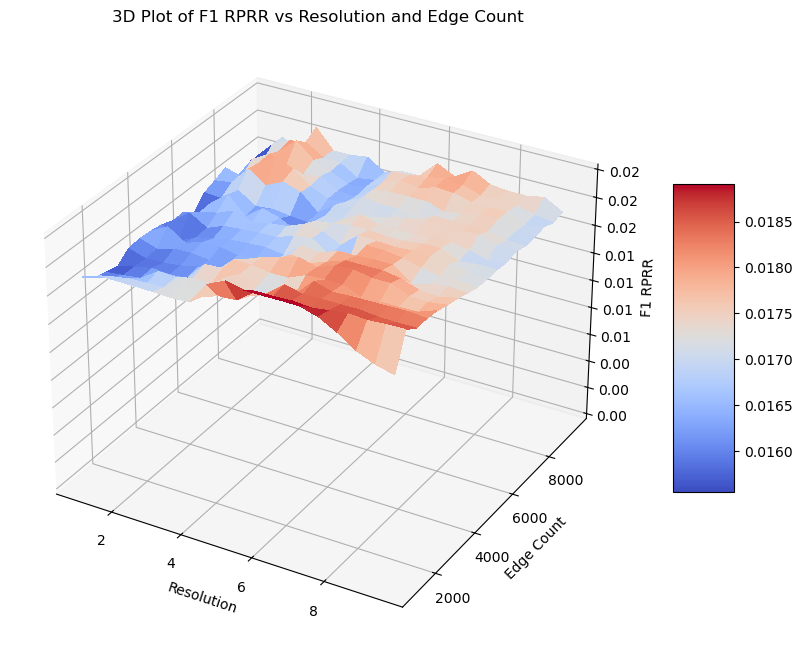

In [37]:
resolution_grid, edge_count_grid = np.meshgrid(sorted(directed_filtered_scores['resolution'].unique()), sorted(directed_filtered_scores['edges'].unique()))

f1rprr_grid_directed_filtered = directed_filtered_scores.pivot(index='edges', columns='resolution', values='f1rprr').values

# 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf_directed = ax.plot_surface(resolution_grid, edge_count_grid, f1rprr_grid_directed_filtered, cmap=cm.coolwarm, linewidth=0, antialiased=False, label='Directed')

# Customize the z axis
ax.set_zlim(0, 0.02)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

# Add labels and title
ax.set_xlabel('Resolution')
ax.set_ylabel('Edge Count')
ax.set_zlabel('F1 RPRR')
ax.set_title('3D Plot of F1 RPRR vs Resolution and Edge Count')

# Add a color bar which maps values to colors
fig.colorbar(surf_directed, shrink=0.5, aspect=5)

plt.show()

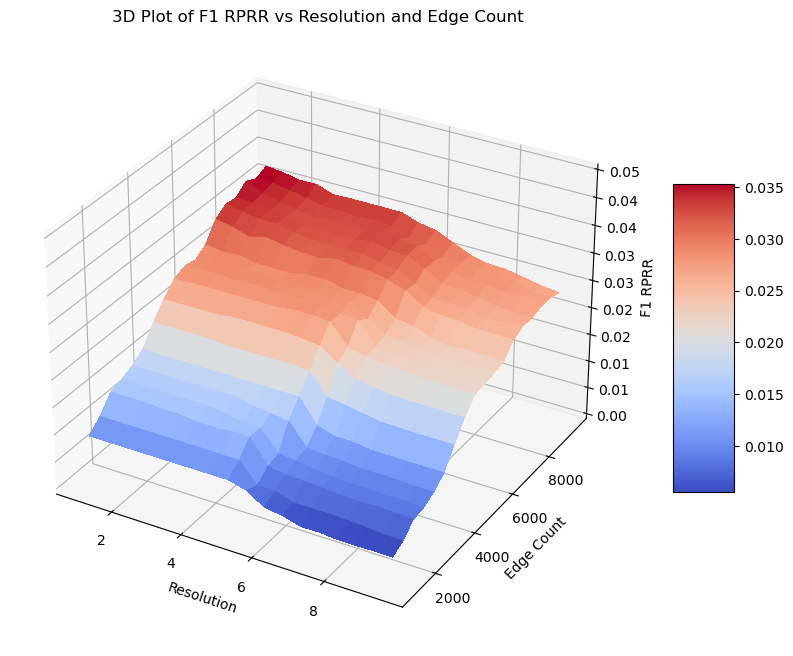

In [38]:
resolution_grid, edge_count_grid = np.meshgrid(sorted(undirected_filtered_scores['resolution'].unique()), sorted(undirected_filtered_scores['edges'].unique()))

f1rprr_grid_undirected_filtered = undirected_filtered_scores.pivot(index='edges', columns='resolution', values='f1rprr').values

# 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf_undirected = ax.plot_surface(resolution_grid, edge_count_grid, f1rprr_grid_undirected_filtered, cmap=cm.coolwarm, linewidth=0, antialiased=False, label='Directed')

# Customize the z axis
ax.set_zlim(0, 0.05)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

# Add labels and title
ax.set_xlabel('Resolution')
ax.set_ylabel('Edge Count')
ax.set_zlabel('F1 RPRR')
ax.set_title('3D Plot of F1 RPRR vs Resolution and Edge Count')

# Add a color bar which maps values to colors
fig.colorbar(surf_undirected, shrink=0.5, aspect=5)

plt.show()

In [12]:
allgenes = sorted(list({g for module in known_modules for g in module}))

In [14]:
directed_list = []
undirected_list = []

for i in range (1000,10000,500):
    for j in range (10,100,5):
        ecoli_trn_undirected = nx.Graph()
        ecoli_trn_undirected.add_weighted_edges_from(
            [tuple(val) for val in genie3_undirected[['regulatoryGene', 'targetGene', 'weight']].head(i).values])
        ecoli_trn_directed = nx.Graph()
        ecoli_trn_directed.add_weighted_edges_from(
            [tuple(val) for val in genie3_directed[['regulatoryGene', 'targetGene', 'weight']].head(i).values])
        res = j/10
        louvain_community_undirected = nx.community.louvain_communities(ecoli_trn_undirected, weight='weight', resolution=res, threshold=1e-7, seed=None)
        louvain_community_directed = nx.community.louvain_communities(ecoli_trn_directed, weight='weight', resolution=res, threshold=1e-7, seed=None)
        louvain_directed_sets = [set(module) for module in louvain_community_directed]
        louvain_undirected_sets = [set(module) for module in louvain_community_undirected]
        ModulesB = Modules(known_modules)
        ModulesA_directed = Modules(louvain_directed_sets)
        ModulesA_undirected = Modules(louvain_undirected_sets)
        undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, allgenes).score(None)
        direct_comp = ModulesComparison(ModulesA_directed, ModulesB, allgenes).score(None)

        directed_list.append((i, res, direct_comp['precision'], direct_comp['recall'], direct_comp['F1rp'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rr'], direct_comp['F1rprr']))
        undirected_list.append((i, res, undirect_comp['precision'], undirect_comp['recall'], undirect_comp['F1rp'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rr'], undirect_comp['F1rprr']))

directed_scores = pd.DataFrame(directed_list, columns=['edges', 'resolution', 'precision', 'recall', 'f1rp', 'recovery', 'relevance', 'f1rr', 'f1rprr'])
undirected_scores = pd.DataFrame(undirected_list, columns=['edges', 'resolution', 'precision', 'recall', 'f1rp', 'recovery', 'relevance', 'f1rr', 'f1rprr'])

In [15]:
directed_scores

,edges,resolution,precision,recall,f1rp,recovery,relevance,f1rr,f1rprr
0,1000,1.0,0.019971,0.048510,0.028293,0.200816,0.163484,0.180237,0.048909
1,1000,1.5,0.020372,0.049923,0.028936,0.206124,0.167406,0.184758,0.050036
2,1000,2.0,0.020372,0.049923,0.028936,0.206124,0.167406,0.184758,0.050036
3,1000,2.5,0.020372,0.049923,0.028936,0.206124,0.167406,0.184758,0.050036
4,1000,3.0,0.020373,0.050588,0.029047,0.204439,0.169222,0.185171,0.050217
...,...,...,...,...,...,...,...,...,...
319,9500,7.5,0.025219,0.057555,0.035071,0.164130,0.138959,0.150500,0.056886
320,9500,8.0,0.025275,0.057544,0.035123,0.158932,0.136858,0.147071,0.056704
321,9500,8.5,0.025274,0.059482,0.035475,0.162361,0.145023,0.153203,0.057610
322,9500,9.0,0.024741,0.059476,0.034946,0.157965,0.145482,0.151467,0.056789


In [16]:
undirected_scores

,edges,resolution,precision,recall,f1rp,recovery,relevance,f1rr,f1rprr
0,1000,1.0,0.007595,0.046442,0.013055,0.145894,0.156099,0.150824,0.024030
1,1000,1.5,0.007595,0.046442,0.013055,0.145894,0.156099,0.150824,0.024030
2,1000,2.0,0.007595,0.046442,0.013055,0.145894,0.156099,0.150824,0.024030
3,1000,2.5,0.007595,0.046442,0.013055,0.145894,0.156099,0.150824,0.024030
4,1000,3.0,0.007595,0.046442,0.013055,0.145894,0.156099,0.150824,0.024030
...,...,...,...,...,...,...,...,...,...
319,9500,7.5,0.026687,0.126455,0.044072,0.109683,0.315259,0.162745,0.069361
320,9500,8.0,0.026637,0.125333,0.043936,0.107459,0.309992,0.159595,0.068903
321,9500,8.5,0.026145,0.122906,0.043118,0.106201,0.308938,0.158066,0.067754
322,9500,9.0,0.025300,0.121162,0.041860,0.105044,0.308498,0.156724,0.066072


In [18]:
max_undirected_f1rp =  undirected_scores.loc[undirected_scores['f1rp'].idxmax()]
max_directed_f1rp = directed_scores.loc[directed_scores['f1rp'].idxmax()]
max_undirected_f1rr =  undirected_scores.loc[undirected_scores['f1rr'].idxmax()]
max_directed_f1rr = directed_scores.loc[directed_scores['f1rr'].idxmax()]
max_undirected_f1rprr = undirected_scores.loc[undirected_scores['f1rprr'].idxmax()]
max_directed_f1rprr = directed_scores.loc[directed_scores['f1rprr'].idxmax()]

print("Resolution and Edges with highest undirected F1rp score:")
print(max_undirected_f1rp)
print("Resolution and Edges directed F1rp score:")
print(max_directed_f1rp)
print("Resolution and Edges with highest undirected F1rr score:")
print(max_undirected_f1rr)
print("Resolution and Edges directed F1rr score:")
print(max_directed_f1rr)
print("Resolution and Edges with highest undirected F1rprr score:")
print(max_undirected_f1rprr)
print("Resolution and Edges directed F1rprr score:")
print(max_directed_f1rprr)

Resolution and Edges with highest undirected F1rp score:
edges         8500.000000
resolution       1.000000
precision        0.036613
recall           0.136549
f1rp             0.057743
recovery         0.112303
relevance        0.303401
f1rr             0.163929
f1rprr           0.085403
Name: 270, dtype: float64
Resolution and Edges directed F1rp score:
edges         9000.000000
resolution       2.000000
precision        0.029030
recall           0.051932
f1rp             0.037242
recovery         0.209418
relevance        0.081504
f1rr             0.117340
f1rprr           0.056539
Name: 290, dtype: float64
Resolution and Edges with highest undirected F1rr score:
edges         4000.000000
resolution       3.000000
precision        0.018558
recall           0.092149
f1rp             0.030895
recovery         0.143245
relevance        0.267068
f1rr             0.186473
f1rprr           0.053007
Name: 112, dtype: float64
Resolution and Edges directed F1rr score:
edges         1500.000